# Setup & Import packages

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import sys

notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

In [3]:
from dotenv import load_dotenv
import os

load_dotenv(override=True)

True

In [4]:
import config

import pytz
import numpy as np
import pandas as pd
import seaborn as sns
from loguru import logger
from datetime import datetime
from matplotlib import pyplot as plt
import scipy.stats as stats
import scikit_posthocs as sp

In [5]:
import asyncio
from typing import List, Optional
from pydantic import BaseModel, Field
from openai import AsyncAzureOpenAI
from tqdm.asyncio import tqdm_asyncio
from tqdm import tqdm
import nest_asyncio

nest_asyncio.apply()

In [6]:
pr_df = pd.read_parquet(config.PR_DF_PATH)

/Users/dungp@backbase.com/Documents/aidev-mining/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
pr_commits_df = pd.read_parquet(config.PR_COMMITS_DF_PATH)

In [8]:
pr_commit_details_df = pd.read_parquet(config.PR_COMMIT_DETAILS_DF_PATH)

In [9]:
human_pr_df = pd.read_parquet(config.HUMAN_PR_DF_PATH)

# 2.1 Assess the PR description quality

## Semantic similarity between commit messages and PR description

In [10]:
human_pr_commit_details_df = pd.read_parquet(config.HUMAN_PR_COMMIT_DETAILS_DF_PATH)

In [11]:
human_pr_commit_details_df.head(2)

,sha,pr_id,file,status,additions,deletions,changes,patch,message,author,author_email,date
0,f76ad8971b774e58f2dd71fbdcb0cc669c1ab7f6,2354816036,Cargo.lock,modified,1,0,1,"@@ -3466,6 +3466,7 @@ dependencies = [\n ""ser...",[cleanup] Move tests from tools/state-viewer t...,Shreyan Gupta,shreyan.gupta96@gmail.com,2025-02-24T21:57:27Z
1,f76ad8971b774e58f2dd71fbdcb0cc669c1ab7f6,2354816036,integration-tests/Cargo.toml,modified,1,0,1,"@@ -54,6 +54,7 @@ near-network.workspace = tru...",[cleanup] Move tests from tools/state-viewer t...,Shreyan Gupta,shreyan.gupta96@gmail.com,2025-02-24T21:57:27Z


In [12]:
pr_df.head(2)

,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url
0,3264933329,2911,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,Claude_Code,108661493,weiliu1031,closed,2025-07-26T02:59:01Z,2025-07-29T07:01:20Z,None,191751505,https://api.github.com/repos/milvus-io/pymilvus,https://github.com/milvus-io/pymilvus/pull/2911
1,3265118634,2,ファイルパス参照を相対パスに統一し、doc/からdocs/に統一,## 背景\n\n現在、本プロジェクトにおいて以下のパス構成の不整合が生じています：\n\n...,Claude_Code,61827001,cm-kojimat,closed,2025-07-26T04:56:55Z,2025-07-26T22:12:24Z,2025-07-26T22:12:24Z,1025472321,https://api.github.com/repos/classmethod/tsumiki,https://github.com/classmethod/tsumiki/pull/2


In [13]:
pr_commits_df.head(2)

,sha,pr_id,author,committer,message
0,15a543882cbad0c9348640cffdd71fb71ac34953,3205734508,rubys,rubys,refactor: Convert Build.Compose from string to...
1,cdd9bab35891037692f1d201db37d34d48342332,3107321792,haasonsaas,haasonsaas,Fix Windows compatibility issues in shell exec...


In [14]:
human_pr_df.head(2)

,id,number,title,user,user_id,state,created_at,closed_at,merged_at,repo_url,html_url,body,agent
0,2336888723,85268,feat(aci): add automations index page,ameliahsu,55610339,closed,2025-02-14T19:04:59Z,2025-02-18T22:42:20Z,2025-02-18T22:42:19Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/85268,https://sentry-j41gpomr5.sentry.dev/automation...,Human
1,2447123365,89131,ref(insights): Make use of `<FeatureBadge>` fo...,ryan953,187460,closed,2025-04-08T23:29:50Z,2025-04-09T15:56:55Z,2025-04-09T15:56:54Z,https://api.github.com/repos/getsentry/sentry,https://github.com/getsentry/sentry/pull/89131,Using the premade component reduces an import ...,Human


In [15]:
def load_df_for_pr_sim(
    pr_commit_details_df: pd.DataFrame, 
    human_pr_commit_details_df: pd.DataFrame,
    pr_df: pd.DataFrame,
    human_pr_df: pd.DataFrame
) -> pd.DataFrame:
    pr_commit_details_df = pr_commit_details_df[pr_commit_details_df['patch'].isnull() == False]
    pr_commit_details_df = pr_commit_details_df[['sha', 'pr_id', 'message']]
    pr_commit_details_df['is_agent'] = 1
    pr_commit_details_df = pr_commit_details_df.drop_duplicates()
    assert pr_commit_details_df.shape[0] == pr_commit_details_df[['pr_id', 'sha']].drop_duplicates().shape[0] # check key

    human_pr_commit_details_df = human_pr_commit_details_df[human_pr_commit_details_df['patch'].isnull() == False]
    human_pr_commit_details_df = human_pr_commit_details_df[['sha', 'pr_id', 'message']]
    human_pr_commit_details_df['is_agent'] = 0
    human_pr_commit_details_df = human_pr_commit_details_df.drop_duplicates()
    assert human_pr_commit_details_df.shape[0] == human_pr_commit_details_df[['pr_id', 'sha']].drop_duplicates().shape[0] # check key

    df = pd.concat([pr_commit_details_df, human_pr_commit_details_df], ignore_index=True)
    assert df.shape[0] == df[['pr_id', 'sha']].drop_duplicates().shape[0] # check key

    pr_df = pr_df[['id', 'title', 'body', 'merged_at']]
    pr_df.columns = ['pr_id', 'pr_title', 'pr_body', 'pr_merged_at']
    human_pr_df = human_pr_df[['id', 'title', 'body', 'merged_at']]
    human_pr_df.columns = ['pr_id', 'pr_title', 'pr_body', 'pr_merged_at']
    combined_df = pd.concat([pr_df, human_pr_df], ignore_index=True)
    combined_df['pr_description'] = combined_df['pr_title'] + ' ' + combined_df['pr_body']
    combined_df.drop(columns=['pr_title', 'pr_body'], inplace=True)

    df = df.merge(combined_df, on='pr_id', how='left')

    df = df[(df['pr_description'].isnull() == False) & (df['message'].isnull() == False)]
    df = df[df['pr_merged_at'].isnull() == False]
    assert df.shape[0] == df[['pr_id', 'sha']].drop_duplicates().shape[0] # check key
    assert df['pr_description'].isnull().sum() == 0 # make sure no missing pr description
    assert df['message'].isnull().sum() == 0 # make sure no missing commit message
    
    return df


In [16]:
df_pr_sim = load_df_for_pr_sim(pr_commit_details_df, human_pr_commit_details_df, pr_df, human_pr_df)

In [17]:
df_pr_sim.head()

,sha,pr_id,message,is_agent,pr_merged_at,pr_description
0,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,Add llms.txt compilation system for AI model d...,1,2025-07-28T21:32:04Z,Add llms.txt compilation system for AI model d...
1,dbd1b5f129f7cffa5ce284d7255814c98bcc38a2,3271196926,Fix lint issues: remove unused variable and ap...,1,2025-07-28T21:32:04Z,Add llms.txt compilation system for AI model d...
2,c2659cfdedf666c8f14753d71664563c2a932b23,3271196926,Update llms.txt to follow official standard wi...,1,2025-07-28T21:32:04Z,Add llms.txt compilation system for AI model d...
3,5361403878396c17f350290fa1782f89aa9e6cae,3271196926,Apply ruff formatting fixes to compilation scr...,1,2025-07-28T21:32:04Z,Add llms.txt compilation system for AI model d...
4,b3c33fe3603254485dbf9f82b19d43ace616fc0a,3271196926,Enhance llms.txt with comprehensive repository...,1,2025-07-28T21:32:04Z,Add llms.txt compilation system for AI model d...


In [18]:
def aggregate_to_pr_level(df: pd.DataFrame) -> pd.DataFrame:
    df = df.groupby(['pr_id', 'is_agent']).agg({'message': ' '.join, 'pr_description': ' '.join}).reset_index()
    return df

In [19]:
df_pr_sim.isnull().sum()

sha               0
pr_id             0
message           0
is_agent          0
pr_merged_at      0
pr_description    0
dtype: int64

In [20]:
df_pr_sim_agg = aggregate_to_pr_level(df_pr_sim)

In [21]:
df_pr_sim_agg.shape

(28081, 4)

In [22]:
df_pr_sim_agg.head()

,pr_id,is_agent,message,pr_description
0,2256777953,0,Bump WebKit again,Bump WebKit again ### What does this PR do?\r\...
1,2256824367,0,filter workspaces when installing Merge branch...,support `bun install --filter <pattern>` ### W...
2,2256920866,0,fix: query,fix: slow lastalert query close https://github...
3,2256962768,0,uilib-native - fix types (for root - i.e. inde...,uilib-native - fix types (for root - i.e. inde...
4,2257021600,0,Release packages,Release packages This PR was opened by the [Ch...


In [71]:
from transformers import pipeline
import torch

model_ckpt = "papluca/xlm-roberta-base-language-detection"
device = 0 if torch.backends.mps.is_available() else -1
pipe = pipeline("text-classification", model=model_ckpt, device=device)

def detect_language(x):
    if not isinstance(x, str) or not x.strip():
        return None, None
    result = pipe(x, top_k=1, truncation=True)[0]
    return result['label'], result['score']


def add_language_confidence(df: pd.DataFrame, column_name: str):
    from tqdm import tqdm
    tqdm.pandas(desc="Detecting language")
    df[['language', 'confidence']] = df[column_name].progress_apply(detect_language).apply(pd.Series)
    return df

In [72]:
df_pr_sim_agg = add_language_confidence(df_pr_sim_agg, 'pr_description')

Detecting language: 100%|██████████| 28081/28081 [09:23<00:00, 49.80it/s]


In [ ]:
# df_pr_sim_agg.to_parquet(config.ANALYSIS_2_1_1_DF_PATH, index=False, engine='pyarrow')

In [23]:
df_pr_sim_agg = pd.read_parquet(config.ANALYSIS_2_1_1_DF_PATH)

In [24]:
df_pr_sim_agg.head()

,pr_id,is_agent,message,pr_description,language,confidence
0,2256777953,0,Bump WebKit again,Bump WebKit again ### What does this PR do?\r\...,en,0.989488
1,2256824367,0,filter workspaces when installing Merge branch...,support `bun install --filter <pattern>` ### W...,en,0.990532
2,2256920866,0,fix: query,fix: slow lastalert query close https://github...,en,0.811629
3,2256962768,0,uilib-native - fix types (for root - i.e. inde...,uilib-native - fix types (for root - i.e. inde...,en,0.466645
4,2257021600,0,Release packages,Release packages This PR was opened by the [Ch...,en,0.955279


In [25]:
def filter_english_and_confidence(df: pd.DataFrame):
    if 'language' not in df.columns or 'confidence' not in df.columns:
        raise ValueError("language and confidence columns are not in the dataframe")
    logger.info(f'{df.shape[0]} rows before filtering')
    df = df[df['language'] == 'en']
    df = df[df['confidence'] > 0.7]
    logger.info(f'{df.shape[0]} rows after filtering')
    df.drop(columns=['language', 'confidence'], axis=1, inplace=True)
    return df

In [26]:
df_pr_sim_agg = filter_english_and_confidence(df_pr_sim_agg)

2025-11-20 12:37:22.200 | INFO     | __main__:filter_english_and_confidence:4 - 28081 rows before filtering
2025-11-20 12:37:22.209 | INFO     | __main__:filter_english_and_confidence:7 - 26642 rows after filtering


In [27]:
df_pr_sim_agg.head()

,pr_id,is_agent,message,pr_description
0,2256777953,0,Bump WebKit again,Bump WebKit again ### What does this PR do?\r\...
1,2256824367,0,filter workspaces when installing Merge branch...,support `bun install --filter <pattern>` ### W...
2,2256920866,0,fix: query,fix: slow lastalert query close https://github...
4,2257021600,0,Release packages,Release packages This PR was opened by the [Ch...
5,2257022379,0,Bump nunit\n\nBumps the dotnet group in /sampl...,Bump nunit from 4.3.1 to 4.3.2 in /samples/sni...


In [28]:
df_pr_sim_agg.is_agent.value_counts()

is_agent
1    22633
0     4009
Name: count, dtype: int64

In [28]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load your embedding model
model = SentenceTransformer('avsolatorio/GIST-Embedding-v0')

# Function to convert a column of texts to embeddings
def add_embeddings(df, text_col, embedding_col):
    """
    Adds a column of embeddings for the given text column.
    """
    embeddings = model.encode(df[text_col].tolist(), show_progress_bar=True)
    df[embedding_col] = list(embeddings)
    return df

# Function to compute row-wise cosine similarity between two embedding columns
def add_similarity(df, emb_col1, emb_col2, sim_col='similarity'):
    """
    Computes cosine similarity row-wise between two embedding columns.
    """
    similarities = np.array([
        cosine_similarity(e1.reshape(1, -1), e2.reshape(1, -1))[0][0]
        for e1, e2 in zip(df[emb_col1], df[emb_col2])
    ])
    df[sim_col] = similarities
    return df

In [29]:
df_pr_sim_agg = add_embeddings(df_pr_sim_agg, 'pr_description', 'pr_description_embedding')

Batches: 100%|██████████| 833/833 [06:22<00:00,  2.18it/s]


In [30]:
df_pr_sim_agg = add_embeddings(df_pr_sim_agg, 'message', 'message_embedding')

Batches: 100%|██████████| 833/833 [01:40<00:00,  8.29it/s]


In [31]:
df_pr_sim_agg = add_similarity(df_pr_sim_agg, 'pr_description_embedding', 'message_embedding')

In [32]:
df_pr_sim_agg.head(2)

,pr_id,is_agent,message,pr_description,pr_description_embedding,message_embedding,similarity
0,2256777953,0,Bump WebKit again,Bump WebKit again ### What does this PR do?\r\...,"[0.020009177, 0.010992475, 0.027312627, 0.0015...","[-0.022720661, -0.017416628, 0.026926702, 0.00...",0.765974
1,2256824367,0,filter workspaces when installing Merge branch...,support `bun install --filter <pattern>` ### W...,"[0.043265533, 0.024298789, 0.02928542, -0.0390...","[0.012198653, 0.011022276, 0.0025873156, 0.007...",0.766970


In [33]:
df_pr_sim_agg.similarity.describe()

count    26642.000000
mean         0.854645
std          0.057257
min          0.537043
25%          0.822474
50%          0.860621
75%          0.892415
max          1.000000
Name: similarity, dtype: float64

In [34]:
df_pr_sim_agg.groupby('is_agent')['similarity'].describe()

,count,mean,std,min,25%,50%,75%,max
is_agent,,,,,,,,
0,4009.0,0.865701,0.074431,0.562542,0.822629,0.874175,0.916956,1.0
1,22633.0,0.852686,0.053409,0.537043,0.822459,0.858837,0.889192,1.0


In [ ]:
# df_pr_sim_agg.to_parquet(config.ANALYSIS_2_1_2_DF_PATH, index=False, engine='pyarrow')

In [33]:
def load_benchmark_df() -> pd.DataFrame:
    df = pd.read_csv(config.DATA_DIR + "/benchmark/cleaned_train.csv")
    return df

In [34]:
cleaned_df = load_benchmark_df()

In [35]:
cleaned_df.head()

,text,description
0,unsigned longs should be compatible with index...,this change allows the type unsigned_long to b...
1,reference to a arrow/_right that doesn't exist...,reference to a arrow/_right that after doesn't...
2,logging user_defined_timestamps_persisted flag...,"as titled, and also removed an undefined and u..."
3,updates validations.py python script. . fixed...,updates validations.py python script. fixed th...
4,[quant][graphmode][fx] support sigmoid/hardsig...,stack from ghstack: #46738 [quant][graphmode][...


In [36]:
cleaned_df.shape

(138895, 2)

In [39]:
pr_sim_benchmark_df = cleaned_df.sample(5000)

In [40]:
pr_sim_benchmark_df.shape

(5000, 2)

In [ ]:
# pr_sim_benchmark_df.to_parquet(config.BENCHMARK_DF_PATH, index=False, engine='pyarrow')

In [41]:
pr_sim_benchmark_df = pd.read_parquet(config.BENCHMARK_DF_PATH)

In [42]:
pr_sim_benchmark_df = add_embeddings(pr_sim_benchmark_df, 'description', 'description_embedding')

Batches: 100%|██████████| 157/157 [00:31<00:00,  4.99it/s]


In [43]:
pr_sim_benchmark_df = add_embeddings(pr_sim_benchmark_df, 'text', 'text_embedding')

Batches: 100%|██████████| 157/157 [00:54<00:00,  2.87it/s]


In [44]:
pr_sim_benchmark_df = add_similarity(pr_sim_benchmark_df, 'description_embedding', 'text_embedding')


In [45]:
pr_sim_benchmark_df.head()

,text,description,description_embedding,text_embedding,similarity
0,9a3c9ae8e roll fuchsia linux sdk from f3b5fctv...,flutter/engine@6a3b046...6c96272 2021-09-08 sk...,"[-0.008590567, -0.054688174, 0.04957798, -0.00...","[0.00094725547, -0.037753712, 0.056386422, -0....",0.944890
1,implemented the volumeslider . fixed an appea...,implemented a new volumeslider component fixed...,"[-0.018662382, 0.03247697, 0.03789267, -0.0011...","[-0.01898533, 0.01116923, 0.036022168, -0.0019...",0.949094
2,temp patch for spark-13566 . fix data type mi...,"fix data type mismatch for decimal, patch for ...","[0.006738966, -0.004792804, -0.0046153064, 0.0...","[0.023793858, -0.049351037, 0.010435293, 0.029...",0.874373
3,"config rewrite enhancement, in case of line lo...","when rewrite the config file, we need read the...","[0.007130689, -0.024861269, -0.019780897, 0.03...","[0.007156514, -0.020222722, -0.031025235, 0.02...",0.975591
4,add npm run update command . npm run update s...,npm run update script should be executed befor...,"[0.006396279, 0.02037356, 0.028058384, 0.00870...","[0.005129872, 0.014332921, 0.019201372, -0.005...",0.965211


In [46]:
pr_sim_benchmark_df.similarity.describe()

count    5000.000000
mean        0.881838
std         0.071943
min         0.554000
25%         0.840638
50%         0.893924
75%         0.937352
max         0.997705
Name: similarity, dtype: float64

In [ ]:
# pr_sim_benchmark_df.to_parquet(config.ANALYSIS_2_1_3_DF_PATH, index=False, engine='pyarrow')

In [49]:
human_ai_sim = df_pr_sim_agg[['is_agent', 'similarity']]

In [50]:
benchmark_sim = pr_sim_benchmark_df[['similarity']]
benchmark_sim['is_agent'] = 2

/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_46442/933019976.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_sim['is_agent'] = 2


In [51]:
boxplot_df = pd.concat([human_ai_sim, benchmark_sim], ignore_index=True)
map = {0: 'HPR', 1: 'APR', 2: 'Benchmark'}
boxplot_df['is_agent'] = boxplot_df['is_agent'].map(map)

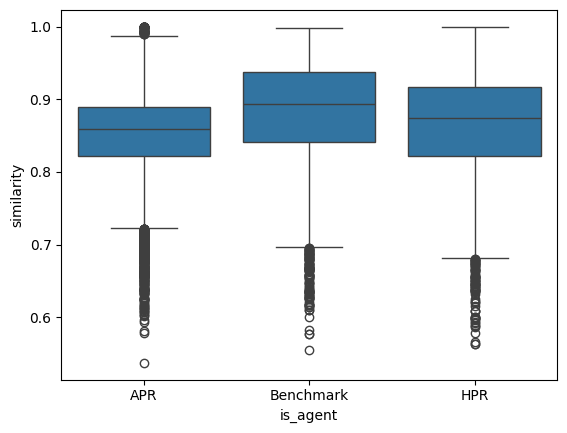

In [58]:
sns.boxplot(x='is_agent', y='similarity', data=boxplot_df.sort_values(by='is_agent'))
plt.show()

In [117]:
# check if normal distribution to apply ANOVA


human_group = boxplot_df[boxplot_df['is_agent'] == 'HPR']['similarity'].values
agent_group = boxplot_df[boxplot_df['is_agent'] == 'APR']['similarity'].values
benchmark_group = boxplot_df[boxplot_df['is_agent'] == 'Benchmark']['similarity'].values

# Check normality for each group
for i, group in enumerate([human_group, agent_group, benchmark_group], start=1):
    stat, p = stats.shapiro(group)
    print(f"Group {i}: W={stat:.3f}, p={p:.3f} -> {'Normal' if p > 0.05 else 'Not normal'}")


Group 1: W=0.971, p=0.000 -> Not normal
Group 2: W=0.972, p=0.000 -> Not normal
Group 3: W=0.937, p=0.000 -> Not normal


In [60]:
human_group = boxplot_df[boxplot_df['is_agent'] == 'HPR']['similarity'].values
agent_group = boxplot_df[boxplot_df['is_agent'] == 'APR']['similarity'].values
benchmark_group = boxplot_df[boxplot_df['is_agent'] == 'Benchmark']['similarity'].values

# Kruskal–Wallis first
h_stat, p_kw = stats.kruskal(human_group, agent_group, benchmark_group)
print(f"Kruskal–Wallis: H={h_stat:.3f}, p={p_kw:.3e}")

if p_kw < 0.05:
    # Combine data for Dunn’s test
    data = np.concatenate([human_group, agent_group, benchmark_group])
    groups = np.array(
        ["G1"] * len(human_group) + ["G2"] * len(agent_group) + 
        ["G3"] * len(benchmark_group)
    )

    # Dunn’s test with Holm correction
    result = sp.posthoc_dunn([human_group, agent_group, benchmark_group], p_adjust='holm')

    print("\nDunn’s post-hoc pairwise p-values (Holm-corrected):")
    print(result)


Kruskal–Wallis: H=1313.111, p=7.270e-286

Dunn’s post-hoc pairwise p-values (Holm-corrected):
              1              2              3
1  1.000000e+00   3.611275e-53   3.079297e-40
2  3.611275e-53   1.000000e+00  2.649060e-266
3  3.079297e-40  2.649060e-266   1.000000e+00


In [61]:
box_plot_df_p1 = boxplot_df.copy()

In [63]:
box_plot_df_p1.head(2) ### use this to combine with the 2 metrics

,is_agent,similarity
0,HPR,0.765974
1,HPR,0.766970


In [534]:
box_plot_df_p1.groupby('is_agent')['similarity'].describe()

,count,mean,std,min,25%,50%,75%,max
is_agent,,,,,,,,
APR,22633.0,0.852686,0.053409,0.537043,0.822459,0.858837,0.889192,1.000000
Benchmark,5000.0,0.881838,0.071943,0.554000,0.840638,0.893924,0.937352,0.997705
HPR,4009.0,0.865701,0.074431,0.562542,0.822629,0.874175,0.916956,1.000000


## Commit message vs diff

In [29]:
splits = {'train': 'train.csv', 'validation': 'val.csv', 'test': 'test.csv'}
df = pd.read_csv("hf://datasets/Maxscha/commitbench/" + splits["test"])

In [30]:
df.shape

(249688, 6)

In [65]:
df.head(2)

,hash,diff,message,project,split,diff_languages
0,713a0a528e7b8ab7348d8e43d3e3aa2e234b20ab,diff --git a/Auth/OpenID/Message.php b/Auth/Op...,[project @ Fix openid.ns value],openid_php-openid,test,php
1,626e13a211c82f833ade88faabcfa104bbf6c7f6,diff --git a/salt/modules/systemd.py b/salt/mo...,fix bug from systems without any legacy init s...,saltstack_salt,test,py


In [66]:
filtered_diff_languages = df.groupby("diff_languages")['hash'].nunique().reset_index()
filtered_diff_languages = filtered_diff_languages[filtered_diff_languages['hash'] > 1000]['diff_languages'].tolist()

In [67]:
df = df[df['diff_languages'].isin(filtered_diff_languages)]

In [68]:
df_sampled = (
    df
    .groupby('diff_languages', group_keys=False)
    .apply(lambda x: x.sample(frac=0.05, random_state=42))
)


/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_46442/520233614.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=0.05, random_state=42))


In [530]:
df_sampled.head(2)

,hash,diff,message,project,split,diff_languages
0,a0c635c0aede2cb0c2f8bb0f0d70485fbdd11bd4,diff --git a/pretty.go b/pretty.go\nindex <HAS...,fix typo in Println description (#<I>),kr_pretty,test,go
1,dc5dcc79701e6d5028c2d25d6cb8fbda9d80f9b7,diff --git a/context.go b/context.go\nindex <H...,Check if context canceled before waiting for M...,nats-io_go-nats,test,go


In [528]:
df_sampled.shape

(12422, 6)

In [70]:
df_sampled.diff_languages.value_counts()

diff_languages
py         3294
js         2630
php        2088
rb         1539
java       1138
go          963
py,py       210
rb,rb       201
js,js       166
php,php     122
go,go        71
Name: count, dtype: int64

In [ ]:
# df_sampled.to_parquet(config.BENCHMARK_COMMITBENCH_DF_PATH, index=False, engine='pyarrow')

In [71]:
df_sampled = pd.read_parquet(config.BENCHMARK_COMMITBENCH_DF_PATH)
df_sampled.head(2)

,hash,diff,message,project,split,diff_languages
0,a0c635c0aede2cb0c2f8bb0f0d70485fbdd11bd4,diff --git a/pretty.go b/pretty.go\nindex <HAS...,fix typo in Println description (#<I>),kr_pretty,test,go
1,dc5dcc79701e6d5028c2d25d6cb8fbda9d80f9b7,diff --git a/context.go b/context.go\nindex <H...,Check if context canceled before waiting for M...,nats-io_go-nats,test,go


In [72]:
def load_patch_for_inference(pr_commit_details_df, human_pr_commit_details_df):
    pr_commit_details_df = pr_commit_details_df[pr_commit_details_df['patch'].isnull() == False]
    pr_commit_details_df = pr_commit_details_df[['sha', 'patch']]
    pr_commit_details_df['is_agent'] = 1
    pr_commit_details_df = pr_commit_details_df.drop_duplicates()
    pr_commit_details_df = pr_commit_details_df.sample(frac=0.05, random_state=42)

    human_pr_commit_details_df = human_pr_commit_details_df[human_pr_commit_details_df['patch'].isnull() == False]
    human_pr_commit_details_df = human_pr_commit_details_df[['sha', 'patch']]
    human_pr_commit_details_df['is_agent'] = 0
    human_pr_commit_details_df = human_pr_commit_details_df.drop_duplicates()
    human_pr_commit_details_df = human_pr_commit_details_df.sample(frac=0.05, random_state=42)

    benchmark_df = pd.read_parquet(config.BENCHMARK_COMMITBENCH_DF_PATH)
    benchmark_df = benchmark_df[['hash', 'diff']]
    benchmark_df.columns = ['sha', 'patch']
    benchmark_df['is_agent'] = 2
    benchmark_df = benchmark_df.drop_duplicates()

    df = pd.concat([pr_commit_details_df, human_pr_commit_details_df, benchmark_df], ignore_index=True)
    # combined patch by sha
    df = df.groupby(['sha', 'is_agent'])['patch'].apply(lambda x: '\n'.join(x)).reset_index()
    assert df.shape[0] == df[['sha', 'is_agent']].drop_duplicates().shape[0] # make sure unique by sha
    return df
    

In [73]:
commit_inference_df = load_patch_for_inference(pr_commit_details_df, human_pr_commit_details_df)

In [74]:
commit_inference_df.head(2)

,sha,is_agent,patch
0,00024cf148680c9d347bd6056e5233f488852923,0,"@@ -8,7 +8,6 @@\n using Microsoft.Build.Execut..."
1,00059a37e7ef6001145737a29f4e81e736111967,1,"@@ -914,7 +914,7 @@ export default class FileO..."


In [75]:
commit_inference_df.shape

(31519, 3)

In [76]:
commit_inference_df.head()

,sha,is_agent,patch
0,00024cf148680c9d347bd6056e5233f488852923,0,"@@ -8,7 +8,6 @@\n using Microsoft.Build.Execut..."
1,00059a37e7ef6001145737a29f4e81e736111967,1,"@@ -914,7 +914,7 @@ export default class FileO..."
2,0006765ca3c5641ef732bad9df58e01f05c6f19c,2,diff --git a/src/store.js b/src/store.js\ninde...
3,0009a2e6c28af5e96208a732c76f9e1e92844f71,2,diff --git a/openquake/commands/tests/commands...
4,000b7184928dbd24b35e16843c65b8f9d74d445f,2,diff --git a/release.py b/release.py\nindex <H...


In [77]:
commit_inference_df.is_agent.value_counts()

is_agent
1    14063
2    12422
0     5034
Name: count, dtype: int64

In [ ]:
# commit_inference_df.to_parquet(config.INFERENCE_COMMIT_MESSAGE_GENERATION_DF_PATH, index=False, engine='pyarrow')

In [194]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("JetBrains-Research/cmg-codet5-without-history")
model_gen = AutoModelForSeq2SeqLM.from_pretrained("JetBrains-Research/cmg-codet5-without-history")

def generate_commit_message(patch: str) -> str:
    inputs = tokenizer(patch, return_tensors="pt", truncation=True)
    outputs = model_gen.generate(**inputs, max_length=2000)
    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return decoded_output

In [195]:
commit_inference_df.head()

,sha,is_agent,patch
0,00024cf148680c9d347bd6056e5233f488852923,0,"@@ -8,7 +8,6 @@\n using Microsoft.Build.Execut..."
1,00059a37e7ef6001145737a29f4e81e736111967,1,"@@ -914,7 +914,7 @@ export default class FileO..."
2,0006765ca3c5641ef732bad9df58e01f05c6f19c,2,diff --git a/src/store.js b/src/store.js\ninde...
3,0009a2e6c28af5e96208a732c76f9e1e92844f71,2,diff --git a/openquake/commands/tests/commands...
4,000b7184928dbd24b35e16843c65b8f9d74d445f,2,diff --git a/release.py b/release.py\nindex <H...


In [196]:
generate_commit_message(commit_inference_df['patch'][4])

'fix: release.py base dir'

In [78]:
# we use google colab to run the inference, this is the output of the run. And the script to run the inference in inference folder
commit_message_gen_result_df = pd.read_parquet(config.INFERENCE_COMMIT_MESSAGE_GENERATION_OUTPUT_DF_PATH)

In [79]:
commit_message_gen_result_df.head()

,sha,is_agent,patch,message
0,00024cf148680c9d347bd6056e5233f488852923,0,"@@ -8,7 +8,6 @@\n using Microsoft.Build.Execut...",Remove unnecessary DisallowNull
1,00059a37e7ef6001145737a29f4e81e736111967,1,"@@ -914,7 +914,7 @@ export default class FileO...",Remove override from FileOrganizer
2,0006765ca3c5641ef732bad9df58e01f05c6f19c,2,diff --git a/src/store.js b/src/store.js\ninde...,cache computed getters
3,0009a2e6c28af5e96208a732c76f9e1e92844f71,2,diff --git a/openquake/commands/tests/commands...,Add test for slow_sources
4,000b7184928dbd24b35e16843c65b8f9d74d445f,2,diff --git a/release.py b/release.py\nindex <H...,fix: release.py base dir


In [80]:
commit_message_gen_result_df = add_embeddings(commit_message_gen_result_df, 'message', 'embedding_message')

Batches: 100%|██████████| 985/985 [00:24<00:00, 40.64it/s]


In [81]:
def get_message_label(df: pd.DataFrame, pr_commit_details_df, human_pr_commit_details_df):
    pr_commit_details_df = pr_commit_details_df[pr_commit_details_df['patch'].isnull() == False]
    pr_commit_details_df = pr_commit_details_df[['sha', 'message']]
    pr_commit_details_df['is_agent'] = 1
    pr_commit_details_df = pr_commit_details_df.drop_duplicates()
    pr_commit_details_df.rename(columns={'message': 'label_message'}, inplace=True)

    human_pr_commit_details_df = human_pr_commit_details_df[human_pr_commit_details_df['patch'].isnull() == False]
    human_pr_commit_details_df = human_pr_commit_details_df[['sha', 'message']]
    human_pr_commit_details_df['is_agent'] = 0
    human_pr_commit_details_df = human_pr_commit_details_df.drop_duplicates()
    human_pr_commit_details_df.rename(columns={'message': 'label_message'}, inplace=True)

    benchmark_df = pd.read_parquet(config.BENCHMARK_COMMITBENCH_DF_PATH)
    benchmark_df = benchmark_df[['hash', 'message']]
    benchmark_df.columns = ['sha', 'label_message']
    benchmark_df['is_agent'] = 2
    benchmark_df = benchmark_df.drop_duplicates()

    combined_df = pd.concat([pr_commit_details_df, human_pr_commit_details_df, benchmark_df], ignore_index=True)
    assert combined_df.shape[0] == combined_df[['sha', 'is_agent']].drop_duplicates().shape[0] # make sure unique by sha
    # combined patch by sha
    df = df.merge(combined_df, on=['sha', 'is_agent'], how='left')
    assert df.shape[0] == df[['sha', 'is_agent']].drop_duplicates().shape[0] # make sure unique by sha
    return df


In [82]:
commit_message_gen_result_df = get_message_label(commit_message_gen_result_df, pr_commit_details_df, human_pr_commit_details_df)

In [83]:
commit_message_gen_result_df.head()

,sha,is_agent,patch,message,embedding_message,label_message
0,00024cf148680c9d347bd6056e5233f488852923,0,"@@ -8,7 +8,6 @@\n using Microsoft.Build.Execut...",Remove unnecessary DisallowNull,"[-0.0023385752, -0.028985387, 0.0069279578, -0...",Enable Nullable Reference Types
1,00059a37e7ef6001145737a29f4e81e736111967,1,"@@ -914,7 +914,7 @@ export default class FileO...",Remove override from FileOrganizer,"[-0.032013353, -0.05510241, 0.03010867, 4.0360...",fix: remove override keyword causing esbuild e...
2,0006765ca3c5641ef732bad9df58e01f05c6f19c,2,diff --git a/src/store.js b/src/store.js\ninde...,cache computed getters,"[-0.01325984, -0.017734429, 0.032016113, 0.019...",fix: fix getters getting re-evaluated on every...
3,0009a2e6c28af5e96208a732c76f9e1e92844f71,2,diff --git a/openquake/commands/tests/commands...,Add test for slow_sources,"[0.0045399675, -0.0133054815, 0.010903581, 0.0...",Added test on `oq show slow_sources`
4,000b7184928dbd24b35e16843c65b8f9d74d445f,2,diff --git a/release.py b/release.py\nindex <H...,fix: release.py base dir,"[-0.015803484, 0.016094852, -0.017886907, 0.01...",bug(release): fix base_dir issue


In [84]:
commit_message_gen_result_df = add_embeddings(commit_message_gen_result_df, 'label_message', 'embedding_label_message')


Batches: 100%|██████████| 985/985 [00:58<00:00, 16.94it/s]


In [85]:
commit_message_gen_result_df = add_similarity(commit_message_gen_result_df, 'embedding_label_message', 'embedding_message')

In [88]:
commit_message_gen_result_df.head(2)

,sha,is_agent,patch,message,embedding_message,label_message,embedding_label_message,similarity
0,00024cf148680c9d347bd6056e5233f488852923,0,"@@ -8,7 +8,6 @@\n using Microsoft.Build.Execut...",Remove unnecessary DisallowNull,"[-0.0023385752, -0.028985387, 0.0069279578, -0...",Enable Nullable Reference Types,"[-0.03956547, 0.0006751268, 0.0012827277, -0.0...",0.709912
1,00059a37e7ef6001145737a29f4e81e736111967,1,"@@ -914,7 +914,7 @@ export default class FileO...",Remove override from FileOrganizer,"[-0.032013353, -0.05510241, 0.03010867, 4.0360...",fix: remove override keyword causing esbuild e...,"[-0.006547211, -0.01630624, 0.040345427, 0.006...",0.811964


In [ ]:
# commit_message_gen_result_df.to_parquet(config.ANALYSIS_2_1_4_DF_PATH, index=False, engine='pyarrow')

In [91]:
commit_message_gen_result_df.groupby('is_agent')['similarity'].describe()

,count,mean,std,min,25%,50%,75%,max
is_agent,,,,,,,,
0,5034.0,0.693483,0.087618,0.494170,0.627865,0.671656,0.748170,1.0
1,14063.0,0.720967,0.090934,0.502399,0.648252,0.704776,0.788599,1.0
2,12422.0,0.774801,0.088154,0.514806,0.708502,0.777539,0.838981,1.0


In [92]:
box_plot_df_p2 = commit_message_gen_result_df[['is_agent', 'similarity']]
# map
map = {0: 'HPR', 1: 'APR', 2: 'Benchmark'}
box_plot_df_p2['is_agent'] = box_plot_df_p2['is_agent'].map(map)
box_plot_df_p2.head(2)

/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_46442/853751375.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  box_plot_df_p2['is_agent'] = box_plot_df_p2['is_agent'].map(map)


,is_agent,similarity
0,HPR,0.709912
1,APR,0.811964


## LLM as a judge

In [94]:
def load_patch_for_inference(pr_commit_details_df, human_pr_commit_details_df):
    pr_commit_details_df['is_missing_patch'] = pr_commit_details_df['patch'].isnull()
    commit_list_missing_patch = pr_commit_details_df[pr_commit_details_df['is_missing_patch'] == True]['sha'].unique()

    pr_commit_details_df = pr_commit_details_df[pr_commit_details_df['sha'].isin(commit_list_missing_patch) == False]
    pr_commit_details_df = pr_commit_details_df[['sha', 'message','patch']]
    pr_commit_details_df['is_agent'] = 1
    pr_commit_details_df = pr_commit_details_df.drop_duplicates()
    pr_commit_details_df = pr_commit_details_df.sample(n=1500, random_state=42)

    human_pr_commit_details_df['is_missing_patch'] = human_pr_commit_details_df['patch'].isnull()
    commit_list_missing_patch = human_pr_commit_details_df[human_pr_commit_details_df['is_missing_patch'] == True]['sha'].unique()
    human_pr_commit_details_df = human_pr_commit_details_df[human_pr_commit_details_df['sha'].isin(commit_list_missing_patch) == False]
    human_pr_commit_details_df = human_pr_commit_details_df[['sha', 'message','patch']]
    human_pr_commit_details_df['is_agent'] = 0
    human_pr_commit_details_df = human_pr_commit_details_df.drop_duplicates()
    human_pr_commit_details_df = human_pr_commit_details_df.sample(n=1500, random_state=42)

    benchmark_df = pd.read_parquet(config.BENCHMARK_COMMITBENCH_DF_PATH)
    benchmark_df = benchmark_df.sample(n=1500, random_state=42)
    benchmark_df = benchmark_df[['hash', 'message','diff']]
    benchmark_df.columns = ['sha', 'message','patch']
    benchmark_df['is_agent'] = 2
    benchmark_df = benchmark_df.drop_duplicates()

    df = pd.concat([pr_commit_details_df, human_pr_commit_details_df, benchmark_df], ignore_index=True)
    # combined patch by sha
    df = df.groupby(['sha', 'is_agent', 'message'])['patch'].apply(lambda x: '\n'.join(x)).reset_index()
    assert df.shape[0] == df[['sha', 'is_agent', 'message']].drop_duplicates().shape[0] # make sure unique by sha
    return df
    

In [95]:
llm_as_judge_df = load_patch_for_inference(pr_commit_details_df, human_pr_commit_details_df)

In [ ]:
# llm_as_judge_df.to_parquet(config.LLM_AS_JUDGE_DF_PATH, index=False, engine='pyarrow')

In [96]:
llm_as_judge_df = pd.read_parquet(config.LLM_AS_JUDGE_DF_PATH)

In [97]:
llm_as_judge_df.head(2)

,sha,is_agent,message,patch
0,000ee5398b07ec4d8f0a47dd72b0b60df65eb7ea,0,"feat: add accordtion, alert, carousel, progres...","@@ -0,0 +1,16 @@\n+import streamlit as st\n+im..."
1,003c6589276968521b4ff7afc4c824a7783bacde,2,Wait for the message to be actually sent befor...,diff --git a/src/exchange-heads.js b/src/excha...


In [98]:
llm_as_judge_df.is_agent.value_counts()

is_agent
2    1500
1    1391
0    1176
Name: count, dtype: int64

In [101]:
class CommitMessageEvaluation(BaseModel):
    """Structured output for commit message evaluation"""
    why_score: int = Field(
        description="Why-expression quality score from 0-5. How clearly the message explains the rationale.",
        ge=0,
        le=5
    )
    what_score: int = Field(
        description="What-expression quality score from 0-5. How clearly the message describes what was changed.",
        ge=0,
        le=5
    )

In [102]:
def load_evaluation_prompt(prompt_path: str = "../data/lllm_as_judge_prompt.md") -> str:
    """Load the evaluation prompt from markdown file"""
    with open(prompt_path, 'r', encoding='utf-8') as f:
        return f.read()

# Load prompt
evaluation_prompt = load_evaluation_prompt()
print(f"Prompt loaded successfully ({len(evaluation_prompt)} characters)")


Prompt loaded successfully (6640 characters)


In [104]:
client = AsyncAzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
)

# Deployment name for your model
DEPLOYMENT_NAME = os.getenv("AZURE_OPENAI_DEPLOYMENT", "gpt-4o")

print(f"Azure OpenAI client initialized with deployment: {DEPLOYMENT_NAME}")


Azure OpenAI client initialized with deployment: gpt-4o


In [105]:
async def evaluate_commit_message(
    commit_message: str,
    patch: str,
    prompt_template: str,
    semaphore: asyncio.Semaphore,
    retry_count: int = 3
) -> Optional[CommitMessageEvaluation]:
    """
    Evaluate a single commit message using Azure OpenAI with structured output.
    
    Args:
        commit_message: The commit message to evaluate
        patch: The diff patch
        prompt_template: The evaluation prompt template
        semaphore: Semaphore to limit concurrent requests
        retry_count: Number of retries on failure
    
    Returns:
        CommitMessageEvaluation object or None if failed
    """
    async with semaphore:
        # Build the full prompt
        user_prompt = f"""
## Commit Message to Evaluate:
```
{commit_message}
```

## Diff Patch:
```diff
{patch}
```

Please evaluate this commit message based on the criteria above and provide the scores.
"""
        
        for attempt in range(retry_count):
            try:
                response = await client.chat.completions.parse(
                    model=DEPLOYMENT_NAME,
                    messages=[
                        {"role": "system", "content": prompt_template},
                        {"role": "user", "content": user_prompt}
                    ],
                    response_format=CommitMessageEvaluation,
                )
                
                # Extract the parsed response
                evaluation = response.choices[0].message.parsed
                return evaluation
                
            except Exception as e:
                if attempt < retry_count - 1:
                    await asyncio.sleep(2 ** attempt)  # Exponential backoff
                else:
                    logger.error(f"Failed to evaluate after {retry_count} attempts: {e}")
                    return None
    
    return None

In [106]:
async def evaluate_dataframe_async(
    df: pd.DataFrame,
    message_column: str = "message",
    patch_column: str = "patch",
    prompt_template: str = None,
    max_concurrent: int = 10,
    batch_size: int = 100
) -> pd.DataFrame:
    """
    Evaluate all commit messages in a dataframe using async Azure OpenAI calls.
    
    Args:
        df: Input dataframe with commit messages and patches
        message_column: Name of column containing commit messages
        patch_column: Name of column containing patches
        prompt_template: The evaluation prompt
        max_concurrent: Maximum number of concurrent API calls
        batch_size: Process in batches to show progress more granularly
    
    Returns:
        DataFrame with added columns: what_score, why_score, explanation
    """
    if prompt_template is None:
        prompt_template = evaluation_prompt
    
    # Create a copy to avoid modifying original
    result_df = df.copy()
    
    # Initialize new columns
    result_df['what_score'] = None
    result_df['why_score'] = None
    # Create semaphore to limit concurrent requests
    semaphore = asyncio.Semaphore(max_concurrent)
    
    # Process in batches for better progress tracking
    total_rows = len(df)
    print(f"Processing {total_rows} commit messages with max {max_concurrent} concurrent requests...")
    
    for batch_start in range(0, total_rows, batch_size):
        batch_end = min(batch_start + batch_size, total_rows)
        batch_df = df.iloc[batch_start:batch_end]
        
        print(f"\nProcessing batch {batch_start//batch_size + 1}/{(total_rows + batch_size - 1)//batch_size} (rows {batch_start}-{batch_end})...")
        
        tasks = []
        index_list = []

        for idx, row in batch_df.iterrows():
            message = row[message_column]
            patch = row[patch_column]
            if pd.isna(message) or pd.isna(patch) or not str(message).strip() or not str(patch).strip():
                continue

            task = evaluate_commit_message(
                commit_message=str(message),
                patch=str(patch),
                prompt_template=prompt_template,
                semaphore=semaphore
            )
            tasks.append(task)
            index_list.append(idx)

        results = await tqdm_asyncio.gather(*tasks, desc=f"Batch {batch_start//batch_size + 1}")

        # Update results
        for idx, evaluation in zip(index_list, results):
            if evaluation is not None:
                result_df.at[idx, "what_score"] = evaluation.what_score
                result_df.at[idx, "why_score"] = evaluation.why_score
    
    # Print summary
    completed = result_df['what_score'].notna().sum()
    print(f"\n✓ Completed: {completed}/{total_rows} evaluations ({completed/total_rows*100:.1f}%)")
    
    return result_df


In [107]:
def evaluate_dataframe(
    df: pd.DataFrame,
    message_column: str = "message",
    patch_column: str = "patch",
    max_concurrent: int = 10,
    batch_size: int = 100
) -> pd.DataFrame:
    """
    Synchronous wrapper for async evaluation function.
    
    Args:
        df: Input dataframe with commit messages and patches
        message_column: Name of column containing commit messages
        patch_column: Name of column containing patches
        max_concurrent: Maximum number of concurrent API calls
        batch_size: Process in batches to show progress
    
    Returns:
        DataFrame with added columns: what_score, why_score, explanation
    """
    return asyncio.run(
        evaluate_dataframe_async(
            df=df,
            message_column=message_column,
            patch_column=patch_column,
            prompt_template=evaluation_prompt,
            max_concurrent=max_concurrent,
            batch_size=batch_size
        )
    )


In [108]:
llm_as_judge_df = pd.read_parquet(config.LLM_AS_JUDGE_DF_PATH)
llm_as_judge_df.is_agent.value_counts()

is_agent
2    1500
1    1391
0    1176
Name: count, dtype: int64

In [ ]:
# long run task
llm_as_judge_with_scores = await evaluate_dataframe_async(
    llm_as_judge_df,
    message_column="message",
    patch_column="patch",
    max_concurrent=20,
    batch_size=100
)

In [ ]:
# llm_as_judge_with_scores.to_parquet(config.LLM_AS_JUDGE_WITH_SCORES_DF_PATH, index=False, engine='pyarrow')

In [109]:
llm_as_judge_with_scores = pd.read_parquet(config.LLM_AS_JUDGE_WITH_SCORES_DF_PATH)

In [110]:
llm_as_judge_with_scores.head(2)

,sha,is_agent,message,patch,what_score,why_score
0,000ee5398b07ec4d8f0a47dd72b0b60df65eb7ea,0,"feat: add accordtion, alert, carousel, progres...","@@ -0,0 +1,16 @@\n+import streamlit as st\n+im...",3,2
1,003c6589276968521b4ff7afc4c824a7783bacde,2,Wait for the message to be actually sent befor...,diff --git a/src/exchange-heads.js b/src/excha...,4,2


In [111]:
llm_as_judge_with_scores['what_score'] = llm_as_judge_with_scores['what_score'].astype(int)
llm_as_judge_with_scores['why_score'] = llm_as_judge_with_scores['why_score'].astype(int)
llm_as_judge_with_scores.groupby('is_agent')['what_score'].describe()

,count,mean,std,min,25%,50%,75%,max
is_agent,,,,,,,,
0,1176.0,1.671769,1.458446,0.0,1.0,1.0,3.0,5.0
1,1391.0,2.350108,1.512180,0.0,1.0,2.0,4.0,5.0
2,1500.0,3.207333,1.034598,0.0,2.0,3.0,4.0,5.0


In [112]:
llm_as_judge_with_scores.groupby('is_agent')['why_score'].describe()

,count,mean,std,min,25%,50%,75%,max
is_agent,,,,,,,,
0,1176.0,1.171769,1.293290,0.0,0.0,1.0,2.0,5.0
1,1391.0,1.689432,1.404985,0.0,1.0,2.0,3.0,5.0
2,1500.0,2.404000,1.371874,0.0,1.0,2.0,3.0,5.0


In [120]:
human_group = llm_as_judge_with_scores[llm_as_judge_with_scores['is_agent'] == 0]['why_score'].values
agent_group = llm_as_judge_with_scores[llm_as_judge_with_scores['is_agent'] == 1]['why_score'].values
benchmark_group = llm_as_judge_with_scores[llm_as_judge_with_scores['is_agent'] == 2]['why_score'].values

# Check normality for each group
for i, group in enumerate([human_group, agent_group, benchmark_group], start=1):
    stat, p = stats.shapiro(group)
    print(f"Group {i}: W={stat:.3f}, p={p:.3f} -> {'Normal' if p > 0.05 else 'Not normal'}")

# If all groups are normal and variances are equal, run ANOVA in the below cell. otherwise, run Kruskal–Wallis test

Group 1: W=0.827, p=0.000 -> Not normal
Group 2: W=0.900, p=0.000 -> Not normal
Group 3: W=0.937, p=0.000 -> Not normal


In [ ]:

f_stat, p_value = stats.f_oneway(human_group, agent_group, benchmark_group)
print(f"\nANOVA: F={f_stat:.3f}, p={p_value:.3e}")

In [114]:
human_group = llm_as_judge_with_scores[llm_as_judge_with_scores['is_agent'] == 0]['why_score'].values
agent_group = llm_as_judge_with_scores[llm_as_judge_with_scores['is_agent'] == 1]['why_score'].values
benchmark_group = llm_as_judge_with_scores[llm_as_judge_with_scores['is_agent'] == 2]['why_score'].values

# Kruskal–Wallis first
h_stat, p_kw = stats.kruskal(human_group, agent_group, benchmark_group)
print(f"Kruskal–Wallis: H={h_stat:.3f}, p={p_kw:.3e}")

if p_kw < 0.05:
    # Combine data for Dunn’s test
    data = np.concatenate([human_group, agent_group, benchmark_group])
    groups = np.array(
        ["G1"] * len(human_group) + ["G2"] * len(agent_group) + 
        ["G3"] * len(benchmark_group)
    )

    # Dunn’s test with Holm correction (you can also use 'bonferroni' or 'fdr_bh')
    result = sp.posthoc_dunn([human_group, agent_group, benchmark_group], p_adjust='holm')

    print("\nDunn’s post-hoc pairwise p-values (Holm-corrected):")
    print(result)

Kruskal–Wallis: H=518.464, p=2.613e-113

Dunn’s post-hoc pairwise p-values (Holm-corrected):
               1             2              3
1   1.000000e+00  2.247842e-21  1.205198e-111
2   2.247842e-21  1.000000e+00   6.859092e-41
3  1.205198e-111  6.859092e-41   1.000000e+00


In [121]:
llm_as_judge_with_scores['total_score'] = llm_as_judge_with_scores['what_score'] + llm_as_judge_with_scores['why_score']

In [122]:
box_plot_df_p3 = llm_as_judge_with_scores[['is_agent', 'total_score']]
box_plot_df_p3['is_agent'] = box_plot_df_p3['is_agent'].map(map)
box_plot_df_p3.head(2)

/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_46442/2613191495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  box_plot_df_p3['is_agent'] = box_plot_df_p3['is_agent'].map(map)


,is_agent,total_score
0,HPR,5
1,Benchmark,6


In [533]:
box_plot_df_p3.groupby('is_agent')['total_score'].describe()

,count,mean,std,min,25%,50%,75%,max
is_agent,,,,,,,,
APR,1391.0,4.039540,2.734120,0.0,2.0,4.0,6.0,10.0
Benchmark,1500.0,5.611333,2.143362,0.0,4.0,6.0,7.0,10.0
HPR,1176.0,2.843537,2.588553,0.0,1.0,2.0,5.0,10.0


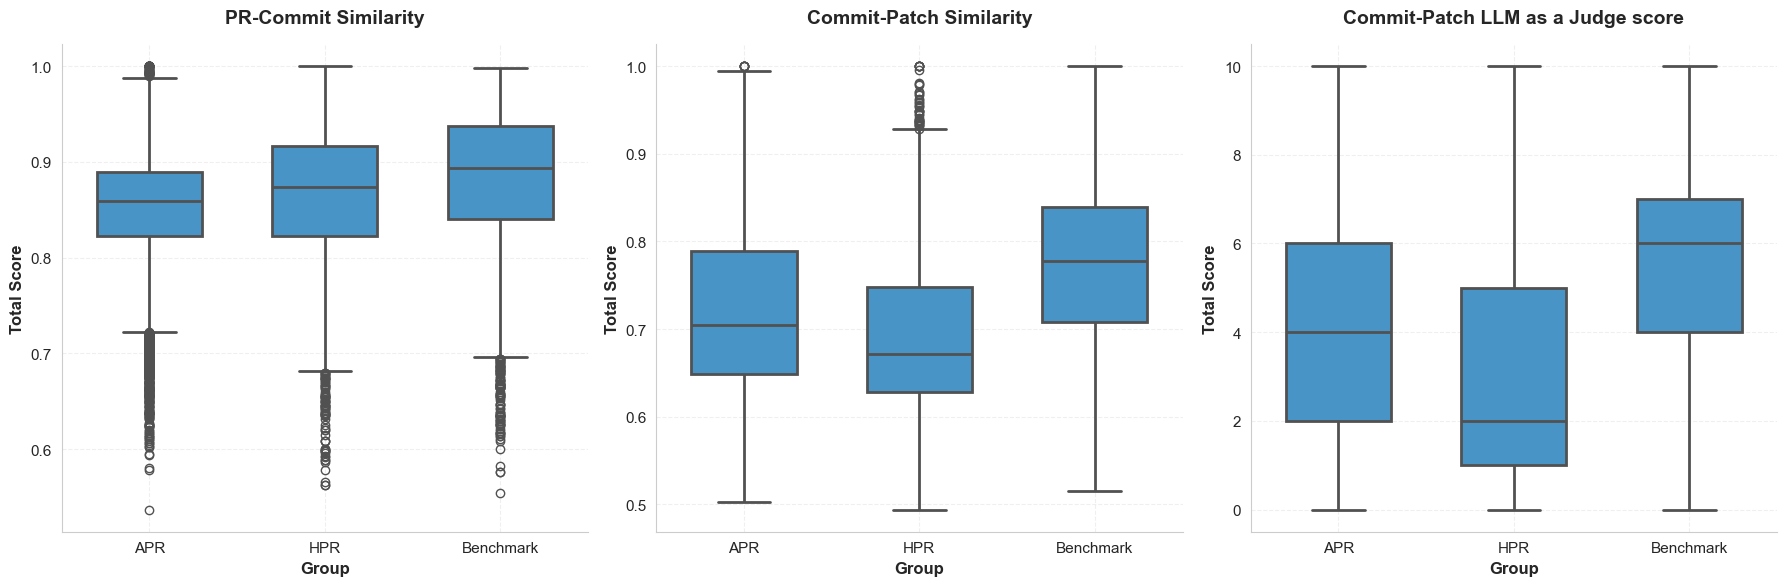

In [535]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for beautiful plots
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 11

# Create figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define a single color for all boxes
box_color = '#3498db'

# Define the order for x-axis
order = ['APR', 'HPR', 'Benchmark']

# Plot 1: Similarity PR description vs commit messages
sns.boxplot(data=box_plot_df_p1, x='is_agent', y='similarity', 
            order=order, color=box_color, ax=axes[0], linewidth=2, width=0.6)
axes[0].set_title('PR-Commit Similarity', 
                   fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Group', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Total Score', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Plot 2: Similarity commit message vs patch
sns.boxplot(data=box_plot_df_p2, x='is_agent', y='similarity', 
            order=order, color=box_color, ax=axes[1], linewidth=2, width=0.6)
axes[1].set_title('Commit-Patch Similarity', 
                   fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Group', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Total Score', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# Plot 3: LLM as a Judge score
sns.boxplot(data=box_plot_df_p3, x='is_agent', y='total_score', 
            order=order, color=box_color, ax=axes[2], linewidth=2, width=0.6)
axes[2].set_title('Commit-Patch LLM as a Judge score', 
                   fontsize=14, fontweight='bold', pad=15)
axes[2].set_xlabel('Group', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Total Score', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3, linestyle='--')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# 2.2 Building classification model

In [126]:
base_df = pr_df[['id', 'title', 'body']]
base_df.columns = ['pr_id', 'pr_title', 'pr_body']

In [127]:
base_df.head()

,pr_id,pr_title,pr_body
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...
1,3265118634,ファイルパス参照を相対パスに統一し、doc/からdocs/に統一,## 背景\n\n現在、本プロジェクトにおいて以下のパス構成の不整合が生じています：\n\n...
2,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...
3,3265709660,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...
4,3265782173,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...


In [164]:
base_df = add_language_confidence(base_df, 'pr_body')

/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_15358/2095008140.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['language', 'confidence']] = df[column_name].apply(detect_language).apply(pd.Series)
/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_15358/2095008140.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['language', 'confidence']] = df[column_name].apply(detect_language).apply(pd.Series)


In [129]:
base_df.head()

,pr_id,pr_title,pr_body
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...
1,3265118634,ファイルパス参照を相対パスに統一し、doc/からdocs/に統一,## 背景\n\n現在、本プロジェクトにおいて以下のパス構成の不整合が生じています：\n\n...
2,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...
3,3265709660,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...
4,3265782173,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...


In [ ]:
# base_df.to_parquet("/Users/dungp@backbase.com/Documents/aidev-mining/data/classification/pr_df_with_language.parquet")

In [77]:
base_df = pd.read_parquet("/Users/dungp@backbase.com/Documents/aidev-mining/data/classification/pr_df_with_language.parquet")

In [78]:
base_df.shape

(33596, 5)

In [79]:
base_df[base_df['confidence'] > 0.7].shape

(31631, 5)

In [80]:
base_df_filtered = base_df[(base_df['confidence'] > 0.7) & (base_df['language'] == 'en')]
base_df_filtered.drop(columns=['confidence', 'language'], axis=1, inplace=True)
base_df_filtered.head()

/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_20253/4239870594.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df_filtered.drop(columns=['confidence', 'language'], axis=1, inplace=True)


,pr_id,pr_title,pr_body
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...
2,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...
3,3265709660,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...
4,3265782173,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...
5,3231949586,feat(swagger): Add Swagger annotations to Batc...,## Summary\nProgressive implementation of Swag...


In [81]:
base_df_filtered.shape

(31404, 3)

In [82]:
base_df_filtered.pr_id.nunique() == base_df_filtered.shape[0]

True

In [83]:
df_pr_sim_agg.head(2)

,pr_id,is_agent,message,pr_description,pr_description_embedding,message_embedding,similarity
0,2256777953,0,Bump WebKit again,Bump WebKit again ### What does this PR do?\r\...,"[0.020009177, 0.010992475, 0.027312627, 0.0015...","[-0.022720661, -0.017416628, 0.026926702, 0.00...",0.765974
1,2256824367,0,filter workspaces when installing Merge branch...,support `bun install --filter <pattern>` ### W...,"[0.043265533, 0.024298789, 0.02928542, -0.0390...","[0.012198653, 0.011022276, 0.0025873156, 0.007...",0.766970


## Build features

In [84]:
def add_pr_title_length(df: pd.DataFrame, column_name: str):
    ''' Number of words in the PR title'''
    df['pr_title_length'] = df[column_name].str.split().str.len()
    return df
base_df_filtered = add_pr_title_length(base_df_filtered, 'pr_title')
base_df_filtered.head()


/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_20253/2166941790.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pr_title_length'] = df[column_name].str.split().str.len()


,pr_id,pr_title,pr_body,pr_title_length
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,12
2,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,7
3,3265709660,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,8
4,3265782173,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...,4
5,3231949586,feat(swagger): Add Swagger annotations to Batc...,## Summary\nProgressive implementation of Swag...,13


In [85]:
def add_pr_body_length(df: pd.DataFrame, column_name: str):
    ''' Number of words in the PR body'''
    df['pr_body_length'] = df[column_name].str.split().str.len()
    return df
base_df_filtered = add_pr_body_length(base_df_filtered, 'pr_body')
base_df_filtered.head()


/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_20253/1368824684.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pr_body_length'] = df[column_name].str.split().str.len()


,pr_id,pr_title,pr_body,pr_title_length,pr_body_length
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,12,256
2,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,7,554
3,3265709660,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,8,312
4,3265782173,chore: remove HashedPostStateProvider trait,## Summary\r\n\r\n#17545 \r\n\r\nRemove the un...,4,37
5,3231949586,feat(swagger): Add Swagger annotations to Batc...,## Summary\nProgressive implementation of Swag...,13,654


In [86]:
def load_pr_task_type_df() -> pd.DataFrame:
    pr_task_type_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_task_type.parquet")
    pr_task_type_df.columns = ['agent', 'pr_id', 'title', 'reason', 'task_type', 'confidence']
    return pr_task_type_df

In [87]:
pr_task_type_df = load_pr_task_type_df()

In [88]:
pr_task_type_df.head(2)

,agent,pr_id,title,reason,task_type,confidence
0,Claude_Code,3264933329,Fix: Wait for all partitions in load_collectio...,title provides conventional commit label,fix,10
1,Claude_Code,3265709660,feat: add comprehensive README screenshots wit...,title provides conventional commit label,feat,10


In [89]:
from loguru import logger

def add_pr_task_type(df: pd.DataFrame, pr_task_type_df: pd.DataFrame):
    pr_task_type_df = pr_task_type_df[['pr_id', 'task_type']]
    df = df.merge(pr_task_type_df, on='pr_id', how='left')
    logger.info(f'{df.shape[0]} rows after merging with pr_task_type_df')
    logger.info(f'task type colummn missing value: {df["task_type"].isnull().sum()}')
    return df

In [90]:
base_df_filtered = add_pr_task_type(base_df_filtered, pr_task_type_df)

2025-11-24 20:29:01.636 | INFO     | __main__:add_pr_task_type:6 - 31404 rows after merging with pr_task_type_df
2025-11-24 20:29:01.637 | INFO     | __main__:add_pr_task_type:7 - task type colummn missing value: 0


In [91]:
base_df_filtered.head(2)

,pr_id,pr_title,pr_body,pr_title_length,pr_body_length,task_type
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,12,256,fix
1,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,7,554,feat


In [92]:
import pandas as pd
import re

def detect_issue_task_linking(df: pd.DataFrame, column_name: str):
    """Extract valid issue/task linking phrases like 'Fixes #123', 'Closes BUG-456', etc."""
    pattern = re.compile(
        r'\b(?:closes|fixes|resolves|related to|issue links?|tickets?)'  # keyword
        r'(?:[:\s]+(?:#\d+|[A-Za-z]{2,}-\d+|[A-Za-z]+-\d+))',            # require proper issue ID format
        flags=re.IGNORECASE
    )

    df['issue_task_linking'] = (
        df[column_name]
        .astype(str)
        .apply(lambda x: "; ".join(re.findall(pattern, x)) or np.nan)
    )

    return df

In [93]:
def add_contains_issue_task_linking(df: pd.DataFrame, column_name: str):
    df = detect_issue_task_linking(df, column_name)
    df['contains_issue_task_linking'] = df['issue_task_linking'].notna()
    df.drop(columns=['issue_task_linking'], axis=1, inplace=True)
    return df

In [94]:
base_df_filtered = add_contains_issue_task_linking(base_df_filtered, 'pr_body')

In [95]:
def detect_common_template_heading(df: pd.DataFrame, column_name: str):
    pattern = re.compile(
    r'(?m)^(?:#+\s*|\s*|:)?(Description|Summary|Motivation|Context|Testing Steps|How to Test|Validation|Checklist|To-Do|Screenshots)\b',
    flags=re.IGNORECASE)

    df['common_template_heading'] = (
        df[column_name]
        .astype(str)
        .apply(lambda x: "; ".join(re.findall(pattern, x)) or np.nan)
    )
    return df

In [96]:
def add_common_template_heading_score(df: pd.DataFrame, column_name: str):
    """Extract common template headings, compute global max list length,
    and assign normalized score (0 if NaN or empty)."""
    df = df.copy()
    
    df = detect_common_template_heading(df, column_name)

    # Create list of unique headings
    df['common_template_heading_list'] = df['common_template_heading'].apply(
        lambda x: list(set(x.split('; '))) if isinstance(x, str) and x.strip() else []
    )

    df['common_template_heading_length'] = df['common_template_heading_list'].apply(len)

    # Compute global max
    max_len = df['common_template_heading_length'].max() or 1
    logger.info(f'max length of common template heading: {max_len}')

    # Compute score for each row
    df['common_template_heading_score'] = df['common_template_heading_length'].apply(
        lambda x: x / max_len if x else 0
    )

    df.drop(columns=['common_template_heading', 'common_template_heading_list', 'common_template_heading_length'], axis=1, inplace=True)

    return df

In [97]:
base_df_filtered.head(2)

,pr_id,pr_title,pr_body,pr_title_length,pr_body_length,task_type,contains_issue_task_linking
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,12,256,fix,False
1,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,7,554,feat,False


In [98]:
base_df_filtered = add_common_template_heading_score(base_df_filtered, 'pr_body')

2025-11-24 20:29:08.197 | INFO     | __main__:add_common_template_heading_score:17 - max length of common template heading: 4


In [99]:
base_df_filtered.head(2)

,pr_id,pr_title,pr_body,pr_title_length,pr_body_length,task_type,contains_issue_task_linking,common_template_heading_score
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,12,256,fix,False,0.25
1,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,7,554,feat,False,0.25


In [100]:
import pandas as pd
import re

def detect_checklist_items(df: pd.DataFrame, column_name: str):
    """Detect checklist items like '- [ ]', '* [x]', or '[ ]' in text."""
    df = df.copy()
    pattern = r'^[\s*]*[-*]?\s*\[[xX\s]\]'
    df['checklist_items'] = df[column_name].apply(
        lambda x: '; '.join(re.findall(pattern, x, flags=re.MULTILINE)) if isinstance(x, str) else np.nan
    )
    return df


def add_contains_checklist_items(df: pd.DataFrame, column_name: str):
    df = df.copy()
    df = detect_checklist_items(df, column_name)
    df['contains_checklist_items'] = df['checklist_items'].notna()
    df.drop(columns=['checklist_items'], axis=1, inplace=True)
    return df

In [101]:
base_df_filtered = add_contains_checklist_items(base_df_filtered, 'pr_body')

In [102]:
def add_total_score_for_pr_template(df: pd.DataFrame):
    df = df.copy()
    df['pr_template_total_score'] = df['contains_issue_task_linking'] + df['common_template_heading_score'] + df['contains_checklist_items']
    return df

In [103]:
base_df_filtered = add_total_score_for_pr_template(base_df_filtered)

In [104]:
base_df_filtered.head(2)

,pr_id,pr_title,pr_body,pr_title_length,pr_body_length,task_type,contains_issue_task_linking,common_template_heading_score,contains_checklist_items,pr_template_total_score
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,12,256,fix,False,0.25,True,1.25
1,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,7,554,feat,False,0.25,True,1.25


In [105]:
def extract_code_snippets(df: pd.DataFrame, column_name: str):
    """Extract only code content from fenced code blocks (``` ... ```)."""
    df = df.copy()
    pattern = re.compile(r'```(?:\w*)\s*([\s\S]*?)```', flags=re.DOTALL)
    df['code_snippets'] = df[column_name].apply(
        lambda x: [code.strip() for code in pattern.findall(x)] if isinstance(x, str) else []
    )
    return df

def add_code_snippets_length_ratio(df: pd.DataFrame, column_name: str):
    df = df.copy()
    df = extract_code_snippets(df, column_name)
    df['code_snippets_length_ratio'] = df['code_snippets'].str.len() / df['pr_body_length']
    df.drop(columns=['code_snippets'], axis=1, inplace=True)
    logger.info(f'shape after extracting code snippets: {df.shape}')
    return df

def add_contains_code_snippets(df: pd.DataFrame, column_name: str):
    '''because the ratio is so small, transform as binary instead'''
    df = df.copy()
    df = extract_code_snippets(df, column_name)
    df['contains_code_snippets'] = df['code_snippets'].str.len() > 0
    df.drop(columns=['code_snippets'], axis=1, inplace=True)
    return df

In [106]:
base_df_filtered = add_contains_code_snippets(base_df_filtered, 'pr_body')

In [107]:
base_df_filtered.head(2)

,pr_id,pr_title,pr_body,pr_title_length,pr_body_length,task_type,contains_issue_task_linking,common_template_heading_score,contains_checklist_items,pr_template_total_score,contains_code_snippets
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,12,256,fix,False,0.25,True,1.25,False
1,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,7,554,feat,False,0.25,True,1.25,True


In [108]:
related_issue_df = pd.read_parquet("hf://datasets/hao-li/AIDev/related_issue.parquet")
issue_df = pd.read_parquet("hf://datasets/hao-li/AIDev/issue.parquet")

In [109]:
def load_related_issue_df() -> pd.DataFrame:
    related_issue_df = pd.read_parquet("hf://datasets/hao-li/AIDev/related_issue.parquet")
    return related_issue_df

In [110]:
def add_number_of_related_issues(df: pd.DataFrame):
    df = df.copy()
    releated_issue_df = load_related_issue_df()
    grp = releated_issue_df.groupby('pr_id')['issue_id'].count().reset_index()
    grp.columns = ['pr_id', 'number_of_related_issues']
    df = df.merge(grp, on='pr_id', how='left')
    logger.info(f'shape after merging with related issue: {df.shape}')
    logger.info(f'percentage of related issues missing value: {df["number_of_related_issues"].isnull().sum()/df.shape[0]}')
    return df

In [111]:
base_df_filtered = add_number_of_related_issues(base_df_filtered)

2025-11-24 20:29:23.412 | INFO     | __main__:add_number_of_related_issues:7 - shape after merging with related issue: (31404, 12)
2025-11-24 20:29:23.413 | INFO     | __main__:add_number_of_related_issues:8 - percentage of related issues missing value: 0.84613425041396


In [112]:
base_df_filtered.head(2)

,pr_id,pr_title,pr_body,pr_title_length,pr_body_length,task_type,contains_issue_task_linking,common_template_heading_score,contains_checklist_items,pr_template_total_score,contains_code_snippets,number_of_related_issues
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,12,256,fix,False,0.25,True,1.25,False,NaN
1,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,7,554,feat,False,0.25,True,1.25,True,NaN


In [113]:
def load_pr_commits_df() -> pd.DataFrame:
    pr_commits_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_commits.parquet")
    return pr_commits_df

In [114]:
pr_commits_df.head()

,sha,pr_id,author,committer,message
0,15a543882cbad0c9348640cffdd71fb71ac34953,3205734508,rubys,rubys,refactor: Convert Build.Compose from string to...
1,cdd9bab35891037692f1d201db37d34d48342332,3107321792,haasonsaas,haasonsaas,Fix Windows compatibility issues in shell exec...
2,219323e2aa1dacd76a422ad24cabf6976c9a6ac0,3107321792,haasonsaas,haasonsaas,Add Windows path validation fixes and comprehe...
3,58c52841e96e9fdcb70befadf7b3994519834861,3107321792,haasonsaas,haasonsaas,Address CodeRabbit review feedback - fix criti...
4,b04470fe6bae5e6802f1fe83e7c5f0b9273e74a3,3107321792,haasonsaas,haasonsaas,Fix Windows compatibility tests - address patt...


In [115]:
def add_number_of_commits(df: pd.DataFrame):
    df = df.copy()
    pr_commits_df = load_pr_commits_df()
    grp = pr_commits_df.groupby('pr_id')['sha'].count().reset_index()
    grp.columns = ['pr_id', 'number_of_commits']
    df = df.merge(grp, on='pr_id', how='left')
    logger.info(f'shape after merging with pr_commits_df: {df.shape}')
    return df


def add_avg_commit_message_length(df: pd.DataFrame):
    '''Number of words in commit messages/number of commits'''
    df = df.copy()
    pr_commits_df = load_pr_commits_df()
    pr_commits_df = pr_commits_df[pr_commits_df['message'].isnull() == False]
    grp = pr_commits_df.groupby('pr_id').agg({'message': ' '.join}).reset_index()
    grp.columns = ['pr_id', 'commit_messages']
    df = df.merge(grp, on='pr_id', how='left')
    df['avg_commit_message_length'] = df['commit_messages'].str.split().str.len() / df['number_of_commits']
    df.drop(columns=['commit_messages'], axis=1, inplace=True)
    logger.info(f'shape after merging with pr_commits_df: {df.shape}')
    logger.info(f'percentage of commit messages missing value: {df["avg_commit_message_length"].isnull().sum()/df.shape[0]}')
    return df

In [116]:
base_df_filtered = add_number_of_commits(base_df_filtered)

2025-11-24 20:29:28.441 | INFO     | __main__:add_number_of_commits:7 - shape after merging with pr_commits_df: (31404, 13)


In [117]:
base_df_filtered = add_avg_commit_message_length(base_df_filtered)
base_df_filtered.head(2)

2025-11-24 20:29:32.087 | INFO     | __main__:add_avg_commit_message_length:21 - shape after merging with pr_commits_df: (31404, 14)
2025-11-24 20:29:32.087 | INFO     | __main__:add_avg_commit_message_length:22 - percentage of commit messages missing value: 0.0004776461597248758


,pr_id,pr_title,pr_body,pr_title_length,pr_body_length,task_type,contains_issue_task_linking,common_template_heading_score,contains_checklist_items,pr_template_total_score,contains_code_snippets,number_of_related_issues,number_of_commits,avg_commit_message_length
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,12,256,fix,False,0.25,True,1.25,False,NaN,1.0,141.000000
1,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,7,554,feat,False,0.25,True,1.25,True,NaN,6.0,31.333333


In [118]:
pr_commit_details_df.head(2)

,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch
0,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,.github/workflows/compile-llms-txt.yml,added,38.0,0.0,38.0,"@@ -0,0 +1,38 @@\n+name: Compile llms.txt\n+\n..."
1,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,docs/compile_llms_txt.py,added,47.0,0.0,47.0,"@@ -0,0 +1,47 @@\n+import os\n+from pathlib im..."


In [119]:
def add_number_of_files_changed(df: pd.DataFrame, pr_commits_details_df: pd.DataFrame):
    df = df.copy()
    grp = pr_commits_details_df.groupby('pr_id')['filename'].nunique().reset_index()
    grp.columns = ['pr_id', 'number_of_files_changed']
    df = df.merge(grp, on='pr_id', how='left')
    return df

def add_commit_stats(df: pd.DataFrame, pr_commits_details_df: pd.DataFrame):
    df = df.copy()
    grp = pr_commits_details_df.groupby('pr_id').agg({'additions': 'sum', 'deletions': 'sum', 'changes': 'sum'}).reset_index()
    grp.columns = ['pr_id', 'total_addition', 'total_deletion', 'total_changes']
    df = df.merge(grp, on='pr_id', how='left')
    return df


def add_number_of_files_by_change_status(df: pd.DataFrame, pr_commits_details_df: pd.DataFrame):
    df = df.copy()
    grp = pr_commits_details_df.groupby(['pr_id', 'status'])['filename'].nunique().reset_index()
    grp.columns = ['pr_id', 'status', 'number_of_files']
    grp = grp.pivot(index='pr_id', columns='status', values='number_of_files').reset_index()
    df = df.merge(grp, on='pr_id', how='left')
    return df

In [120]:
pr_commit_details_df.head(2)


,sha,pr_id,author,committer,message,commit_stats_total,commit_stats_additions,commit_stats_deletions,filename,status,additions,deletions,changes,patch
0,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,.github/workflows/compile-llms-txt.yml,added,38.0,0.0,38.0,"@@ -0,0 +1,38 @@\n+name: Compile llms.txt\n+\n..."
1,2f9d54dda4f0c87c19e0bbeb9936f525d0587e16,3271196926,devin-ai-integration[bot],devin-ai-integration[bot],Add llms.txt compilation system for AI model d...,23008,23008,0,docs/compile_llms_txt.py,added,47.0,0.0,47.0,"@@ -0,0 +1,47 @@\n+import os\n+from pathlib im..."


In [121]:
base_df_filtered_add_commits = add_number_of_files_changed(base_df_filtered, pr_commit_details_df)

In [122]:
base_df_filtered_add_commits = add_commit_stats(base_df_filtered_add_commits, pr_commit_details_df)

In [123]:
base_df_filtered_add_commits = add_number_of_files_by_change_status(base_df_filtered_add_commits, pr_commit_details_df)

In [124]:
base_df_filtered_add_commits.head(2)

,pr_id,pr_title,pr_body,pr_title_length,pr_body_length,task_type,contains_issue_task_linking,common_template_heading_score,contains_checklist_items,pr_template_total_score,...,number_of_commits,avg_commit_message_length,number_of_files_changed,total_addition,total_deletion,total_changes,added,modified,removed,renamed
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,12,256,fix,False,0.25,True,1.25,...,1.0,141.000000,3.0,394.0,2.0,396.0,1.0,2.0,NaN,NaN
1,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,7,554,feat,False,0.25,True,1.25,...,6.0,31.333333,5.0,298.0,109.0,407.0,1.0,4.0,NaN,NaN


In [125]:
def add_number_of_modules_l1_changed(df: pd.DataFrame, pr_commits_details_df: pd.DataFrame):
    df = df.copy()
    spread_df = pr_commits_details_df[['pr_id', 'filename']]
    spread_df['module'] = spread_df['filename'].str.split('/')
    condition = spread_df['module'].str.len() >= 2
    spread_df['spread_up_1_level'] = np.nan
    spread_df.loc[condition, 'spread_up_1_level'] = spread_df.loc[condition, 'module'].str[-2]
    grp = spread_df.groupby('pr_id')['spread_up_1_level'].nunique().reset_index()
    grp.columns = ['pr_id', 'number_of_modules_l1_changed']
    df = df.merge(grp, on='pr_id', how='left')
    return df


def add_number_of_modules_l2_changed(df: pd.DataFrame, pr_commits_details_df: pd.DataFrame):
    df = df.copy()
    spread_df = pr_commits_details_df[['pr_id', 'filename']]
    spread_df['module'] = spread_df['filename'].str.split('/')
    condition = spread_df['module'].str.len() >= 3
    spread_df['spread_up_2_level'] = np.nan
    spread_df.loc[condition, 'spread_up_2_level'] = spread_df.loc[condition, 'module'].str[-3]
    grp = spread_df.groupby('pr_id')['spread_up_2_level'].nunique().reset_index()
    grp.columns = ['pr_id', 'number_of_modules_l2_changed']
    df = df.merge(grp, on='pr_id', how='left')
    return df

In [126]:
base_df_filtered_add_commits = add_number_of_modules_l1_changed(base_df_filtered_add_commits, pr_commit_details_df)
# base_df_filtered_add_commits = add_number_of_modules_l2_changed(base_df_filtered_add_commits, pr_commit_details_df)

/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_20253/264109511.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spread_df['module'] = spread_df['filename'].str.split('/')
/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_20253/264109511.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spread_df['spread_up_1_level'] = np.nan
/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_20253/264109511.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will ra

## Mark label 

In [127]:
base_df_filtered_add_commits.head(2)

,pr_id,pr_title,pr_body,pr_title_length,pr_body_length,task_type,contains_issue_task_linking,common_template_heading_score,contains_checklist_items,pr_template_total_score,...,avg_commit_message_length,number_of_files_changed,total_addition,total_deletion,total_changes,added,modified,removed,renamed,number_of_modules_l1_changed
0,3264933329,Fix: Wait for all partitions in load_collectio...,## Summary\n\nFixes an issue where `load_colle...,12,256,fix,False,0.25,True,1.25,...,141.000000,3.0,394.0,2.0,396.0,1.0,2.0,NaN,NaN,2.0
1,3265640341,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,7,554,feat,False,0.25,True,1.25,...,31.333333,5.0,298.0,109.0,407.0,1.0,4.0,NaN,NaN,2.0


In [128]:
base_df_filtered_add_commits['pr_id'].nunique()

31404

In [129]:
df_pr_sim_agg = pd.read_parquet(config.ANALYSIS_2_1_2_DF_PATH)

In [130]:
df_pr_sim_agg.head(2)

,pr_id,is_agent,message,pr_description,pr_description_embedding,message_embedding,similarity
0,2256777953,0,Bump WebKit again,Bump WebKit again ### What does this PR do?\r\...,"[0.020009177, 0.010992475, 0.027312627, 0.0015...","[-0.022720661, -0.017416628, 0.026926702, 0.00...",0.765974
1,2256824367,0,filter workspaces when installing Merge branch...,support `bun install --filter <pattern>` ### W...,"[0.043265533, 0.024298789, 0.02928542, -0.0390...","[0.012198653, 0.011022276, 0.0025873156, 0.007...",0.766970


In [131]:
def load_label(base_df_filtered, df_pr_sim_agg):
    base_df_filtered = base_df_filtered.merge(df_pr_sim_agg[['pr_id', 'similarity']], on='pr_id', how='inner')
    return base_df_filtered
train_df = load_label(base_df_filtered_add_commits, df_pr_sim_agg)

train_df['label'] = train_df['similarity'].apply(lambda x: 1 if x >= 0.9 else 0)
train_df.drop(columns=['pr_title','pr_body', 'similarity', 'total_changes'], axis=1, inplace=True)

In [132]:
train_df.head()

,pr_id,pr_title_length,pr_body_length,task_type,contains_issue_task_linking,common_template_heading_score,contains_checklist_items,pr_template_total_score,contains_code_snippets,number_of_related_issues,...,avg_commit_message_length,number_of_files_changed,total_addition,total_deletion,added,modified,removed,renamed,number_of_modules_l1_changed,label
0,3265640341,7,554,feat,False,0.25,True,1.25,True,NaN,...,31.333333,5.0,298.0,109.0,1.0,4.0,NaN,NaN,2.0,1
1,3265709660,8,312,feat,False,0.50,True,1.50,False,NaN,...,138.333333,15.0,288.0,12.0,13.0,4.0,NaN,NaN,3.0,1
2,3214555104,6,666,feat,False,0.00,True,1.00,True,NaN,...,7.000000,3.0,620.0,0.0,2.0,1.0,NaN,NaN,2.0,0
3,3214724259,8,233,feat,False,0.25,True,1.25,False,NaN,...,42.500000,6.0,1013.0,340.0,NaN,6.0,NaN,NaN,4.0,0
4,3214782537,10,3202,refactor,True,0.25,True,2.25,True,1.0,...,15.933333,64.0,1725.0,1103.0,7.0,55.0,2.0,9.0,31.0,0


In [133]:
train_df.shape

(22161, 21)

## One-hot the task_type

In [134]:
train_df.isnull().sum()

pr_id                                0
pr_title_length                      0
pr_body_length                       0
task_type                            0
contains_issue_task_linking          0
common_template_heading_score        0
contains_checklist_items             0
pr_template_total_score              0
contains_code_snippets               0
number_of_related_issues         19987
number_of_commits                    0
avg_commit_message_length            0
number_of_files_changed              0
total_addition                       0
total_deletion                       0
added                            12566
modified                          1480
removed                          19582
renamed                          21262
number_of_modules_l1_changed         0
label                                0
dtype: int64

In [135]:
train_df.fillna(0, inplace=True)

In [136]:
# one-hot the task_type
train_df = pd.get_dummies(train_df, columns=['task_type'])

In [137]:
train_df.head()

,pr_id,pr_title_length,pr_body_length,contains_issue_task_linking,common_template_heading_score,contains_checklist_items,pr_template_total_score,contains_code_snippets,number_of_related_issues,number_of_commits,...,task_type_ci,task_type_docs,task_type_feat,task_type_fix,task_type_other,task_type_perf,task_type_refactor,task_type_revert,task_type_style,task_type_test
0,3265640341,7,554,False,0.25,True,1.25,True,0.0,6.0,...,False,False,True,False,False,False,False,False,False,False
1,3265709660,8,312,False,0.50,True,1.50,False,0.0,3.0,...,False,False,True,False,False,False,False,False,False,False
2,3214555104,6,666,False,0.00,True,1.00,True,0.0,1.0,...,False,False,True,False,False,False,False,False,False,False
3,3214724259,8,233,False,0.25,True,1.25,False,0.0,4.0,...,False,False,True,False,False,False,False,False,False,False
4,3214782537,10,3202,True,0.25,True,2.25,True,1.0,30.0,...,False,False,False,False,False,False,True,False,False,False


In [138]:
train_df.drop(['contains_issue_task_linking', 'common_template_heading_score', 'contains_checklist_items'], axis=1, inplace=True) # use total score column only

In [139]:
train_df.shape

(22161, 29)

## Train model

In [140]:
train_df.drop(columns=['pr_id'], axis=1, inplace=True)

In [141]:
X = train_df.drop(columns=["label"]) # features 
y = train_df["label"] # target

In [142]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb


def train_and_evaluate(X, y, model_name: str):
    """
    Train and evaluate a classification model and return metrics as a DataFrame.

    Parameters:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series): Target labels.
        model_name (str): One of ['rf', 'xgboost', 'lightgbm', 'SVM', 'KNN'].

    Returns:
        pd.DataFrame: A single-row DataFrame containing model_name, accuracy, auc, precision, recall, f1.
    """

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Select model
    if model_name == "rf":
        model = RandomForestClassifier(random_state=42)
    elif model_name == "xgboost":
        model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    elif model_name == "lightgbm":
        model = lgb.LGBMClassifier(random_state=42)
    elif model_name == "SVM":
        model = SVC(probability=True, random_state=42)
    elif model_name == "KNN":
        model = KNeighborsClassifier()
    else:
        raise ValueError("Invalid model_name. Choose from ['rf', 'xgboost', 'lightgbm', 'SVM', 'KNN'].")

    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None and len(y.unique()) == 2 else None

    # Create metrics DataFrame
    metrics_df = pd.DataFrame([{
        "model_name": model_name,
        "accuracy": accuracy,
        "auc": auc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }])

    return metrics_df, model, X_train, X_test, y_train, y_test

In [143]:
metrics_df_rf, model_rf, X_train, X_test, y_train, y_test = train_and_evaluate(X, y, model_name='rf')
metrics_df_rf

,model_name,accuracy,auc,precision,recall,f1
0,rf,0.86217,0.798601,0.728358,0.319372,0.44404


In [410]:
metrics_df_knn, model_knn, X_train, X_test, y_train, y_test = train_and_evaluate(X, y, model_name='KNN')
metrics_df_knn

,model_name,accuracy,auc,precision,recall,f1
0,KNN,0.828784,0.645412,0.508039,0.206806,0.293953


In [412]:
metrics_df_lightgbm, model_lightgbm, X_train, X_test, y_train, y_test = train_and_evaluate(X, y, model_name='lightgbm')
metrics_df_lightgbm

[LightGBM] [Info] Number of positive: 3053, number of negative: 14675
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1932
[LightGBM] [Info] Number of data points in the train set: 17728, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.172213 -> initscore=-1.570021
[LightGBM] [Info] Start training from score -1.570021


,model_name,accuracy,auc,precision,recall,f1
0,lightgbm,0.857207,0.805273,0.682451,0.320681,0.436331


In [413]:
metrics_df_xgboost, model_xgboost, X_train, X_test, y_train, y_test = train_and_evaluate(X, y, model_name='xgboost')
metrics_df_xgboost

/Users/dungp@backbase.com/Documents/aidev-mining/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:06:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,model_name,accuracy,auc,precision,recall,f1
0,xgboost,0.849312,0.786056,0.618227,0.328534,0.42906


In [414]:
metrics_df_svm, model_svm, X_train, X_test, y_train, y_test = train_and_evaluate(X, y, model_name='SVM')
metrics_df_svm

,model_name,accuracy,auc,precision,recall,f1
0,SVM,0.826979,0.73008,0.0,0.0,0.0


In [415]:
pd.concat([metrics_df_rf, metrics_df_knn, metrics_df_lightgbm, metrics_df_xgboost, metrics_df_svm], ignore_index=True)

,model_name,accuracy,auc,precision,recall,f1
0,rf,0.862170,0.798601,0.728358,0.319372,0.444040
1,KNN,0.828784,0.645412,0.508039,0.206806,0.293953
2,lightgbm,0.857207,0.805273,0.682451,0.320681,0.436331
3,xgboost,0.849312,0.786056,0.618227,0.328534,0.429060
4,SVM,0.826979,0.730080,0.000000,0.000000,0.000000


AUC: 0.7986


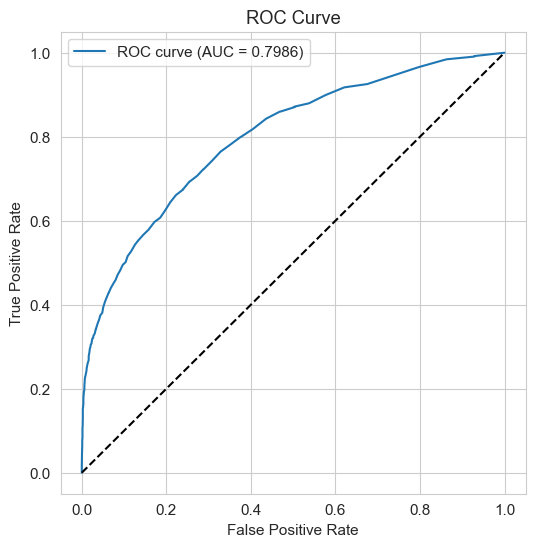

In [383]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (assuming binary classification)
y_prob = rf.predict_proba(X_test)[:, 1]

# Compute AUC
auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc:.4f}")

# Optional: plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line for random
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


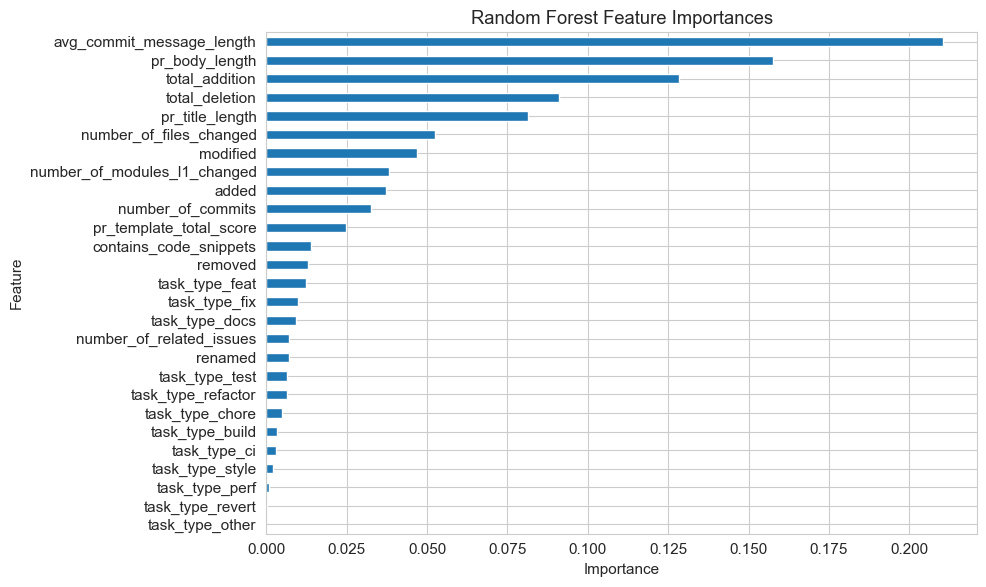

In [416]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming rf is your trained RandomForestClassifier and X_train exists
feature_importances = pd.Series(model_rf.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=True)  # ascending for horizontal bar

# Plot
plt.figure(figsize=(10, 6))
feature_importances.plot(kind="barh")
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## SHAP analysis

In [144]:
X_test.head(2)

,pr_title_length,pr_body_length,pr_template_total_score,contains_code_snippets,number_of_related_issues,number_of_commits,avg_commit_message_length,number_of_files_changed,total_addition,total_deletion,...,task_type_ci,task_type_docs,task_type_feat,task_type_fix,task_type_other,task_type_perf,task_type_refactor,task_type_revert,task_type_style,task_type_test
5376,3,33,1.25,False,0.0,1.0,3.000000,1.0,64.0,40.0,...,False,False,True,False,False,False,False,False,False,False
658,10,253,2.00,True,1.0,3.0,9.333333,1.0,11.0,7.0,...,False,False,True,False,False,False,False,False,False,False


In [145]:
import shap

# Create explainer
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(X_test)


In [148]:
import numpy as np

shap_values_class_1 = shap_values[:, :, 1]

shap_abs = np.abs(shap_values_class_1)
mean_abs = shap_abs.mean(axis=0)

top5_idx = np.argsort(mean_abs)[-5:]

top5_features = X_test.iloc[:, top5_idx]
top5_shap = shap_values_class_1[:, top5_idx]

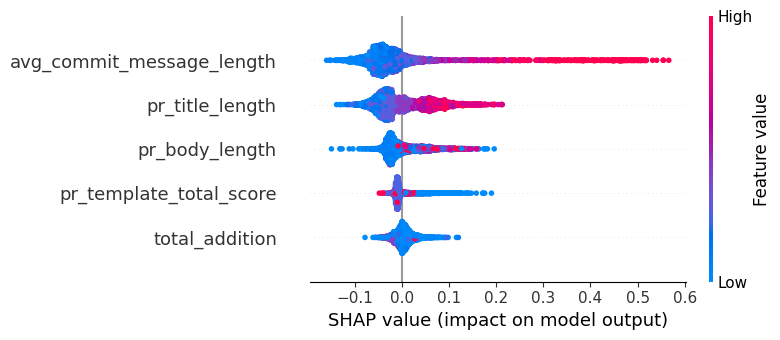

In [149]:
shap.summary_plot(top5_shap, top5_features)

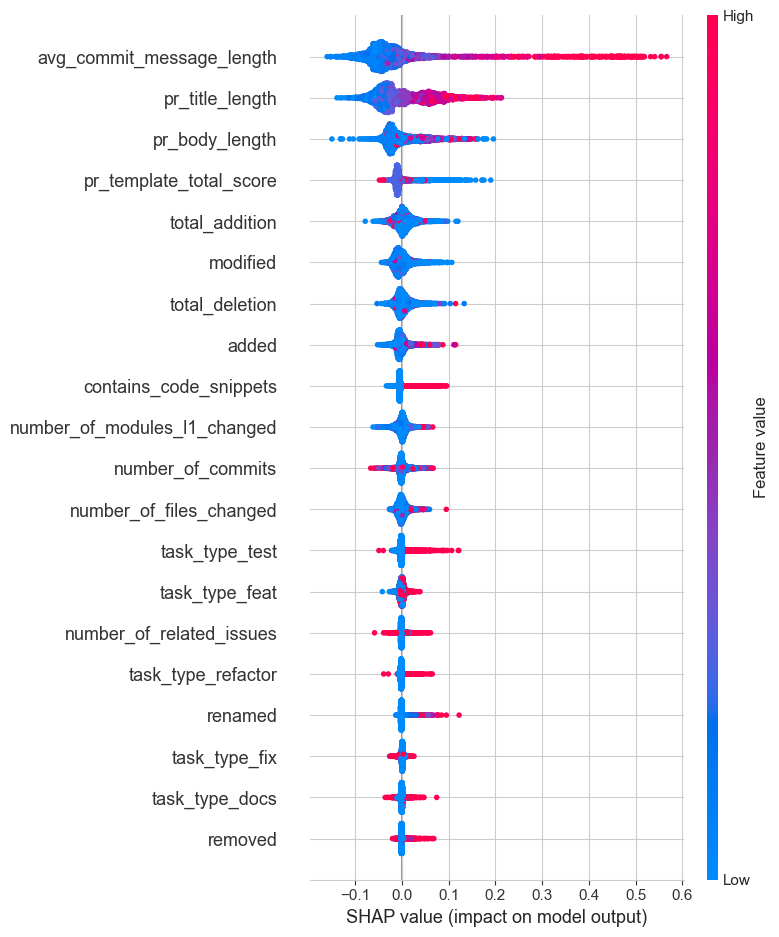

In [418]:
# Summary plot for all features
shap.summary_plot(shap_values[:, :, 1], X_test)  # [1] for positive class in binary classification


In [421]:
shap_values[1].shape

(27, 2)

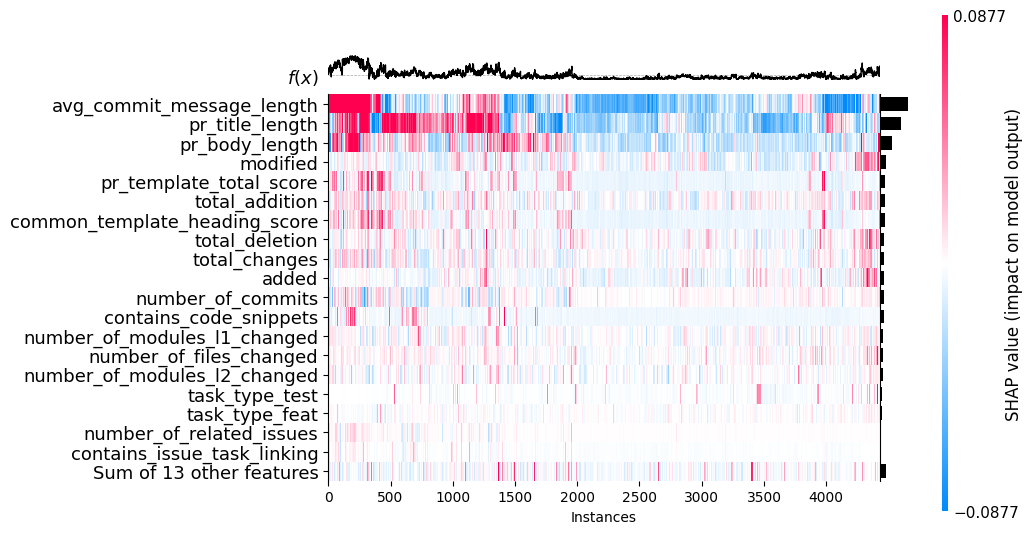

In [470]:
import shap
import matplotlib.pyplot as plt

# Extract SHAP values for the class of interest (e.g., class index 1)
shap_values_to_plot = shap_values[:, :, 1]  # shape: (n_samples, n_features)

# Create the Explanation object
shap_exp = shap.Explanation(
    values=shap_values_to_plot,
    base_values=explainer.expected_value[1] if isinstance(explainer.expected_value, (list, tuple)) else explainer.expected_value,
    data=X_test,
    feature_names=X_test.columns
)

# Plot SHAP value heatmap
shap.plots.heatmap(shap_exp, max_display=20)
plt.show()


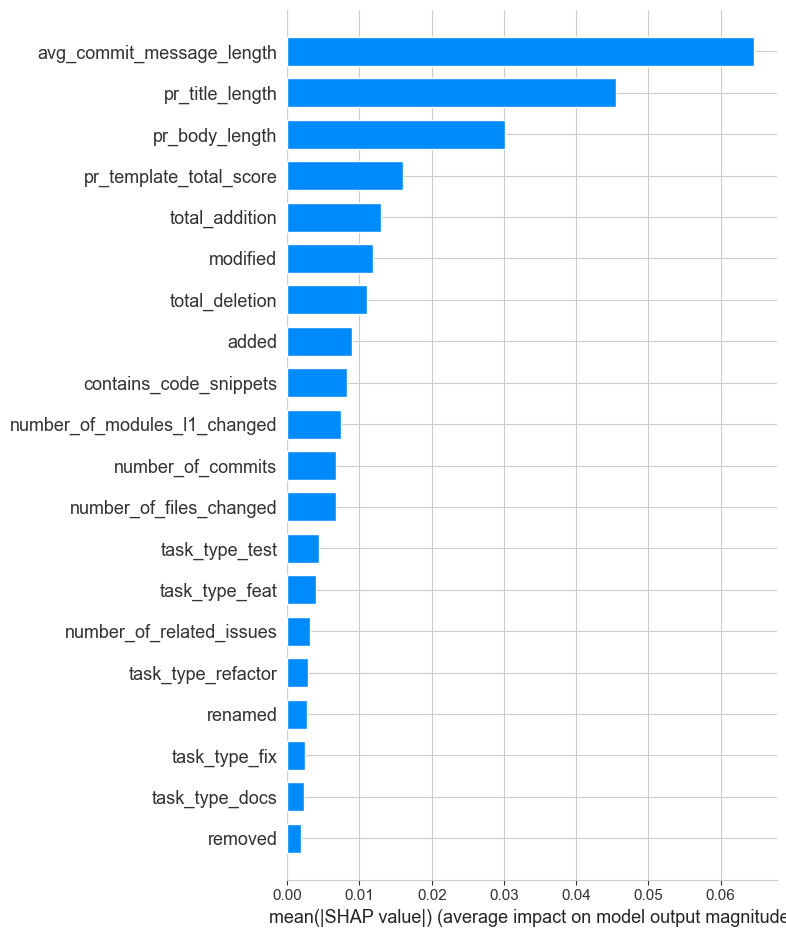

In [419]:
shap.summary_plot(shap_values[:, :, 1], X_test, plot_type="bar")

In [477]:
explainer.expected_value

array([0.82732401, 0.17267599])

In [424]:
y_prob

array([0.05, 0.18, 0.25, ..., 0.1 , 0.25, 0.03], shape=(4433,))

In [425]:
np.where(y_prob >= 0.7)[0]

array([  12,   44,   49,   88,  121,  131,  179,  213,  231,  247,  285,
        317,  322,  326,  328,  336,  404,  407,  437,  456,  474,  493,
        495,  499,  513,  524,  605,  607,  643,  682,  714,  754,  827,
        860,  883,  900,  911,  948, 1146, 1170, 1185, 1206, 1207, 1247,
       1253, 1280, 1294, 1298, 1332, 1333, 1352, 1430, 1438, 1446, 1481,
       1485, 1542, 1547, 1601, 1647, 1691, 1701, 1810, 1852, 1858, 1863,
       1876, 1892, 1902, 1916, 1965, 1977, 1993, 2054, 2056, 2057, 2087,
       2098, 2116, 2140, 2141, 2179, 2197, 2207, 2262, 2278, 2317, 2350,
       2378, 2401, 2426, 2436, 2447, 2452, 2465, 2471, 2502, 2504, 2511,
       2520, 2555, 2672, 2678, 2725, 2784, 2800, 2804, 2810, 2822, 2832,
       2837, 2846, 2860, 2898, 2946, 2955, 2997, 2998, 3023, 3027, 3046,
       3081, 3120, 3156, 3181, 3224, 3241, 3248, 3305, 3309, 3313, 3333,
       3362, 3462, 3487, 3559, 3564, 3600, 3610, 3629, 3640, 3652, 3663,
       3717, 3755, 3770, 3808, 3861, 3947, 3974, 40

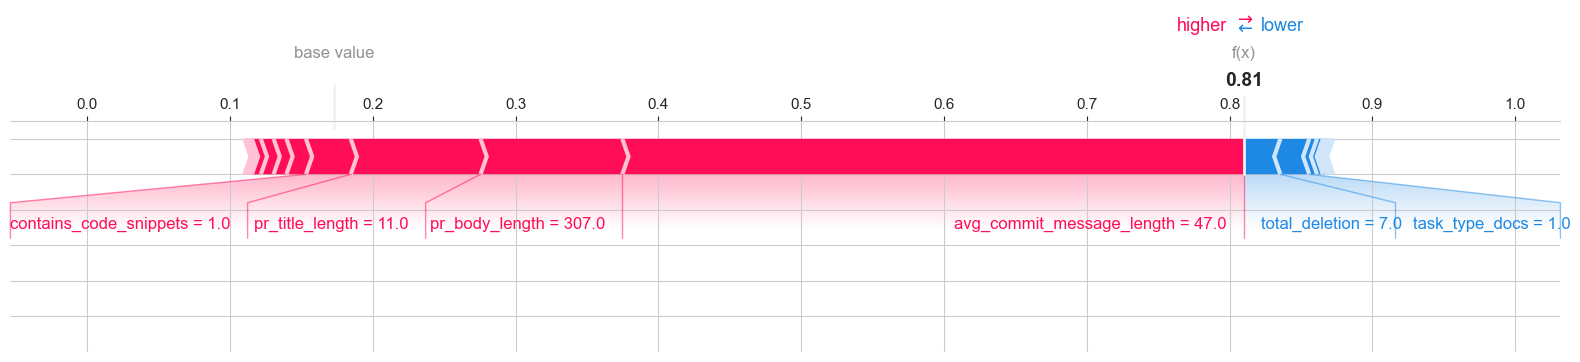

In [426]:
sample_idx = 900
class_idx = 1  # the class you want to visualize

shap.force_plot(
    explainer.expected_value[class_idx],       # expected value for that class
    shap_values[sample_idx, :, class_idx],     # SHAP values for this sample & class
    X_test.iloc[sample_idx],                   # feature values
    matplotlib=True
)
plt.show()

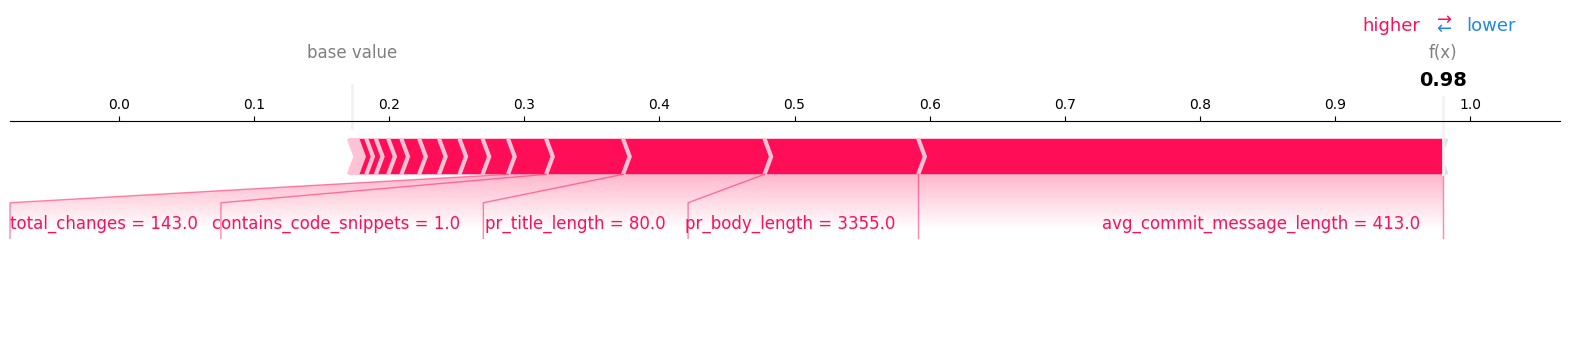

In [491]:
sample_idx = 2946
class_idx = 1  # the class you want to visualize

shap.force_plot(
    explainer.expected_value[class_idx],       # expected value for that class
    shap_values[sample_idx, :, class_idx],     # SHAP values for this sample & class
    X_test.iloc[sample_idx],                   # feature values
    matplotlib=True
)
plt.show()

In [442]:
X_train.dtypes

pr_title_length                   int64
pr_body_length                    int64
pr_template_total_score         float64
contains_code_snippets             bool
number_of_related_issues        float64
number_of_commits               float64
avg_commit_message_length       float64
number_of_files_changed         float64
total_addition                  float64
total_deletion                  float64
added                           float64
modified                        float64
removed                         float64
renamed                         float64
number_of_modules_l1_changed    float64
task_type_build                    bool
task_type_chore                    bool
task_type_ci                       bool
task_type_docs                     bool
task_type_feat                     bool
task_type_fix                      bool
task_type_other                    bool
task_type_perf                     bool
task_type_refactor                 bool
task_type_revert                   bool


In [444]:
explainer.expected_value

array([0.82732401, 0.17267599])

In [472]:
explanation = shap.Explanation(shap_values[:, :, 1], explainer.expected_value[1], X_test, feature_names=X_test.columns)

In [473]:
explanation.shape

(4433, 27)

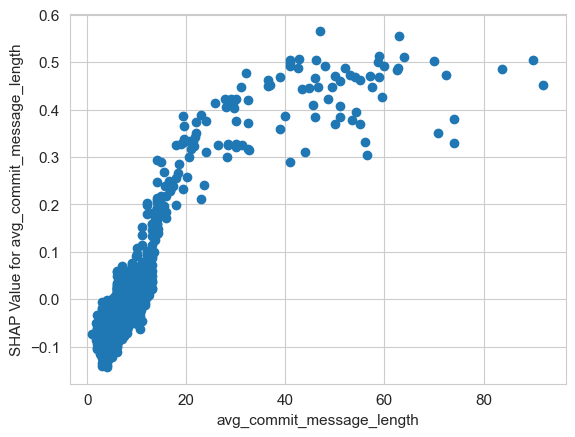

In [515]:
single_feature_exp = explanation[:, "avg_commit_message_length"]
df_pr_title_length = pd.DataFrame({
    'feature_value': single_feature_exp.data,
    'shap_value': single_feature_exp.values
})

df_pr_title_length_plot = df_pr_title_length.sample(2000, random_state=42)
df_pr_title_length_plot = df_pr_title_length_plot[df_pr_title_length_plot['feature_value'] < 100]
# df_pr_title_length_plot = df_pr_title_length_plot[df_pr_title_length_plot['feature_value'] < 30]
plt.scatter(df_pr_title_length_plot['feature_value'], df_pr_title_length_plot['shap_value'])
plt.xlabel("avg_commit_message_length")
plt.ylabel("SHAP Value for avg_commit_message_length")
plt.show()

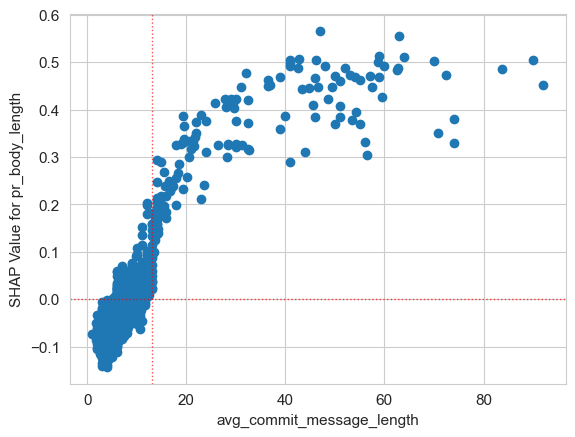

In [513]:
single_feature_exp = explanation[:, "avg_commit_message_length"]
df_pr_title_length = pd.DataFrame({
    'feature_value': single_feature_exp.data,
    'shap_value': single_feature_exp.values
})

df_pr_title_length_plot = df_pr_title_length.sample(2000, random_state=42)
df_pr_title_length_plot = df_pr_title_length_plot[df_pr_title_length_plot['feature_value'] < 100]
# df_pr_title_length_plot = df_pr_title_length_plot[df_pr_title_length_plot['feature_value'] < 30]
plt.scatter(df_pr_title_length_plot['feature_value'], df_pr_title_length_plot['shap_value'])
plt.xlabel("avg_commit_message_length")
plt.ylabel("SHAP Value for pr_body_length")

# Add red dotted lines
plt.axhline(y=0, color='red', linestyle=':', linewidth=1, alpha=0.7)  # Horizontal line at y=0
plt.axvline(x=13, color='red', linestyle=':', linewidth=1, alpha=0.7)  # Vertical line at x=7

plt.show()

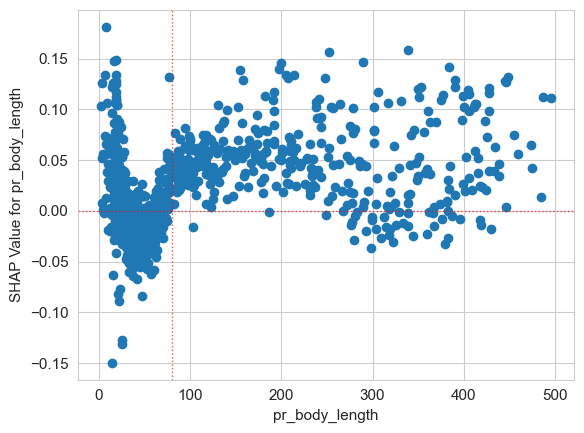

In [523]:
single_feature_exp = explanation[:, "pr_body_length"]
df_pr_title_length = pd.DataFrame({
    'feature_value': single_feature_exp.data,
    'shap_value': single_feature_exp.values
})

df_pr_title_length_plot = df_pr_title_length.sample(2000, random_state=42)
df_pr_title_length_plot = df_pr_title_length_plot[df_pr_title_length_plot['feature_value'] < 500]
# df_pr_title_length_plot = df_pr_title_length_plot[df_pr_title_length_plot['feature_value'] < 30]
plt.scatter(df_pr_title_length_plot['feature_value'], df_pr_title_length_plot['shap_value'])
plt.xlabel("pr_body_length")
plt.ylabel("SHAP Value for pr_body_length")
plt.axhline(y=0, color='red', linestyle=':', linewidth=1, alpha=0.7)  # Horizontal line at y=0
plt.axvline(x=80, color='red', linestyle=':', linewidth=1, alpha=0.7)  # Vertical line at x=7
plt.show()

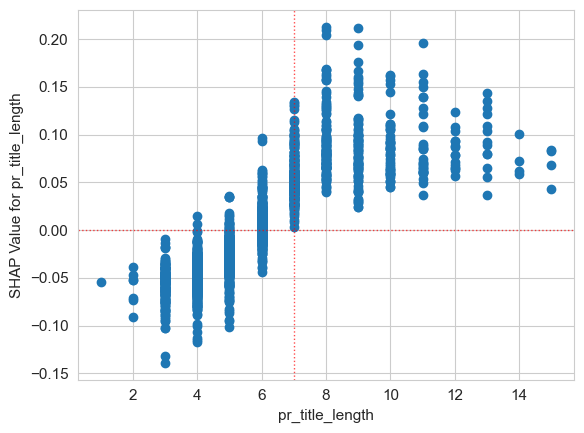

In [ ]:
single_feature_exp = explanation[:, "pr_title_length"]
df_pr_title_length = pd.DataFrame({
    'feature_value': single_feature_exp.data,
    'shap_value': single_feature_exp.values
})

df_pr_title_length_plot = df_pr_title_length.sample(2000, random_state=42)
plt.scatter(df_pr_title_length_plot['feature_value'], df_pr_title_length_plot['shap_value'])
plt.xlabel("pr_title_length")
plt.ylabel("SHAP Value for pr_title_length")

# Add red dotted lines
plt.axhline(y=0, color='red', linestyle=':', linewidth=1, alpha=0.7)  # Horizontal line at y=0
plt.axvline(x=7, color='red', linestyle=':', linewidth=1, alpha=0.7)  # Vertical line at x=7

plt.show()

In [489]:
# find index of array that has the highest probability
y_prob[y_prob.argmax()]


np.float64(0.98)

In [490]:
y_prob.argmax()

np.int64(2946)

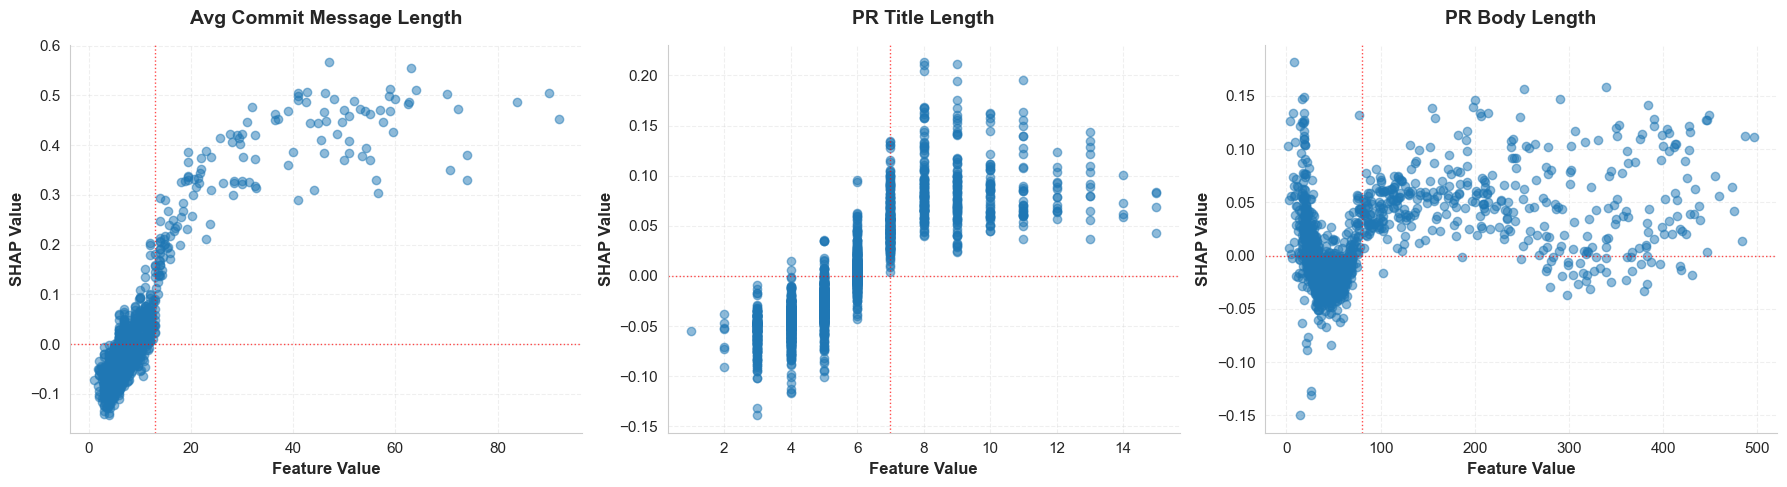

In [525]:
import matplotlib.pyplot as plt

# Create figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: avg_commit_message_length
single_feature_exp = explanation[:, "avg_commit_message_length"]
df_avg_commit = pd.DataFrame({
    'feature_value': single_feature_exp.data,
    'shap_value': single_feature_exp.values
})
df_avg_commit_plot = df_avg_commit.sample(2000, random_state=42)
df_avg_commit_plot = df_avg_commit_plot[df_avg_commit_plot['feature_value'] < 100]
axes[0].scatter(df_avg_commit_plot['feature_value'], df_avg_commit_plot['shap_value'], alpha=0.5)
axes[0].set_xlabel("Feature Value", fontsize=12, fontweight='bold')
axes[0].set_ylabel("SHAP Value", fontsize=12, fontweight='bold')
axes[0].set_title("Avg Commit Message Length", fontsize=14, fontweight='bold', pad=15)
axes[0].axhline(y=0, color='red', linestyle=':', linewidth=1, alpha=0.7)
axes[0].axvline(x=13, color='red', linestyle=':', linewidth=1, alpha=0.7)
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Plot 2: pr_title_length
single_feature_exp = explanation[:, "pr_title_length"]
df_pr_title_length = pd.DataFrame({
    'feature_value': single_feature_exp.data,
    'shap_value': single_feature_exp.values
})
df_pr_title_length_plot = df_pr_title_length.sample(2000, random_state=42)
axes[1].scatter(df_pr_title_length_plot['feature_value'], df_pr_title_length_plot['shap_value'], alpha=0.5)
axes[1].set_xlabel("Feature Value", fontsize=12, fontweight='bold')
axes[1].set_ylabel("SHAP Value", fontsize=12, fontweight='bold')
axes[1].set_title("PR Title Length", fontsize=14, fontweight='bold', pad=15)
axes[1].axhline(y=0, color='red', linestyle=':', linewidth=1, alpha=0.7)
axes[1].axvline(x=7, color='red', linestyle=':', linewidth=1, alpha=0.7)
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# Plot 3: pr_body_length
single_feature_exp = explanation[:, "pr_body_length"]
df_pr_body_length = pd.DataFrame({
    'feature_value': single_feature_exp.data,
    'shap_value': single_feature_exp.values
})
df_pr_body_length_plot = df_pr_body_length.sample(2000, random_state=42)
df_pr_body_length_plot = df_pr_body_length_plot[df_pr_body_length_plot['feature_value'] < 500]
axes[2].scatter(df_pr_body_length_plot['feature_value'], df_pr_body_length_plot['shap_value'], alpha=0.5)
axes[2].set_xlabel("Feature Value", fontsize=12, fontweight='bold')
axes[2].set_ylabel("SHAP Value", fontsize=12, fontweight='bold')
axes[2].set_title("PR Body Length", fontsize=14, fontweight='bold', pad=15)
axes[2].axhline(y=0, color='red', linestyle=':', linewidth=1, alpha=0.7)
axes[2].axvline(x=80, color='red', linestyle=':', linewidth=1, alpha=0.7)
axes[2].grid(True, alpha=0.3, linestyle='--')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Post analysis

In [312]:
ai_df = pr_commit_details_df[['pr_id', 'sha', 'message']].drop_duplicates()
ai_df['commit_message_len'] = ai_df['message'].str.len()
ai_df.commit_message_len.describe()

count    88563.000000
mean       104.415365
std        270.725669
min          1.000000
25%         31.000000
50%         56.000000
75%        125.000000
max      54214.000000
Name: commit_message_len, dtype: float64

In [308]:
human_df = human_pr_commit_details_df[['pr_id', 'sha', 'message']].drop_duplicates()
human_df['commit_message_len'] = human_df['message'].str.len()
human_df.commit_message_len.describe()

count    27198.000000
mean       107.076550
std        652.208168
min          0.000000
25%         19.000000
50%         38.000000
75%         66.000000
max      65516.000000
Name: commit_message_len, dtype: float64

In [310]:
ai_df = pr_df[['id', 'title', 'body']]
ai_df['body_len'] = ai_df['body'].str.len()
ai_df.body_len.describe()

/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_25328/2061394174.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ai_df['body_len'] = ai_df['body'].str.len()


count    33236.000000
mean       940.919966
std       1657.329252
min          1.000000
25%        276.000000
50%        387.000000
75%        956.000000
max      77435.000000
Name: body_len, dtype: float64

In [311]:
human_df = human_pr_df[['id', 'title', 'body']]
human_df['body_len'] = human_df['body'].str.len()
human_df.body_len.describe()

/var/folders/c9/c0h9fzn53kg8bh90ry875l8c0000gp/T/ipykernel_25328/3358459174.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_df['body_len'] = human_df['body'].str.len()


count     5623.000000
mean      2136.398186
std       5656.123998
min          2.000000
25%        228.000000
50%        690.000000
75%       1873.500000
max      80113.000000
Name: body_len, dtype: float64